# **Zero-Shot** Text Classification with ***Siamese Network***

Este notebook incluye la preparación del dataset por pares, la arquitectura de la red siamesa y el entrenamiento en KERAS.

# Librerías

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
%%capture
!pip install livelossplot ## track del entrenamiento

In [ ]:
from livelossplot import PlotLossesKeras

In [ ]:
%%capture
!pip install wandb 
import wandb
from wandb.keras import WandbCallback

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install keras

In [ ]:
%%capture
import tensorflow as tf
import keras
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Concatenate, Conv2D, Flatten, Dense, Embedding, LSTM
from keras.models import Model


# Preparación del dataset
- Necesario crear pares de datos de entrada: 
  - 2 frases 
  - is_equal = 0 o 1 dependiendo de si las frases tienen significado similar o no 


##Load Amazon Dataset English/Spanish & create pairs (only the first time)


In [ ]:
path1 = "/content/drive/MyDrive/TFG/Datasets_procesados_2/train/amazonEN_train.csv"
path2 = "/content/drive/MyDrive/TFG/Datasets_procesados_2/valid/amazonEN_valid.csv"
path3 = "/content/drive/MyDrive/TFG/Datasets_procesados_2/test/amazonEN_test.csv"

In [ ]:
df_train = pd.read_csv(path1)
df_valid = pd.read_csv(path2)
df_test = pd.read_csv(path3)

In [ ]:
df_train.head(2)

,review_id,product_id,reviewer_id,star_rating,review_body,review_title,language,product_category,text_title,text_title_cat,text_cat,product_category_cod
0,en_0522546,product_en_0681589,reviewer_en_0687817,2,Not strong enough to run a small 120v vacuum c...,Not strong enough to run a small 120v vacuum c...,en,lawn_and_garden,Not strong enough to run a small 120v vacuum c...,Not strong enough to run a small 120v vacuum c...,Not strong enough to run a small 120v vacuum c...,17
1,en_0612910,product_en_0295449,reviewer_en_0312138,1,"The leg openings are a little small, but other...",Crap,en,apparel,"Crap The leg openings are a little small, but ...","Crap The leg openings are a little small, but ...","The leg openings are a little small, but other...",0


### Create pairs english

In [ ]:
# Agrupamos por puntuaciones 
star0 = df_train[df_train["star_rating"] == 0]
star1 = df_train[df_train["star_rating"] == 1]
star2 = df_train[df_train["star_rating"] == 2]
star3 = df_train[df_train["star_rating"] == 3]
star4 = df_train[df_train["star_rating"] == 4]

In [ ]:
star4.shape

(40000, 12)

In [ ]:
#Creamos funcion para hacer pares de cada grupo de puntuaciones 
def create_pairs(df):
  partitions = 2
  star0s = np.array_split(df, partitions)

  star01 = star0s[0]['review_body']
  star01 = star01.reset_index()
  star01.rename(columns={'review_body': 'sent1'}, inplace=True)


  star02 = star0s[1]['review_body']
  star02 = star02.reset_index()
  star02.rename(columns={'review_body': 'sent2'}, inplace=True)

  final1s = pd.DataFrame()
  final1s = pd.concat([star01,star02],axis=1)
  final1s = final1s.drop('index',axis=1)
  final1s['is_duplicate'] = 1
  return final1s

In [ ]:
# Cada grupo de puntuaciones dividido en dos y puesto en dos columnas sent1 y sent2  + is_duplicate = 1 porque son del mismo grupo == aprox mismo significado
pair_0s = create_pairs(star0)[:5000].reset_index(drop=True)
pair_1s = create_pairs(star1)[:5000].reset_index(drop=True)
pair_2s = create_pairs(star2)[:5000].reset_index(drop=True)
pair_3s = create_pairs(star3)[:5000].reset_index(drop = True)
pair_4s = create_pairs(star4)[:5000].reset_index(drop=True)

#Ejemplo del resultado
pair_0s.head(4)

,sent1,sent2,is_duplicate
0,"Very, very thin, you can bend them with you fi...",I am EXTREMELY unhappy and wish I could give i...,1
1,Super cute! Loved it until I noticed that the ...,I did not receive this item even though Amazon...,1
2,Broke down after a month's use!!,Ordered 2. Both were broke when they arrived. ...,1
3,It's hard to be critical of something so inexp...,Remote stopped working one month after purchase,1


In [ ]:
#Descartamos el 2 , pares entre 0-1 y 3-4 
result_pairs = pd.DataFrame()
result_pairs = pd.concat([pair_0s,pair_1s,pair_3s,pair_4s],ignore_index=True)


In [ ]:
result_pairs = result_pairs.sample(frac=1).reset_index(drop=True)

In [ ]:
result_pairs

,sent1,sent2,is_duplicate
0,They were nice not as comfortable as I thought,Worked for what we needed until we can actuall...,1
1,alarm did not go off 3 days out of 5. am sendi...,"order wrong one's, shipped back to amazon, alt...",1
2,twist on earing part sucks.,One of the markers came broken and leaking.,1
3,"Honestly, nothing too special. The masks slid ...",I have no idea why most of the reviews claim t...,1
4,This was such a tiny leaf and half eaten not ok,Bought them about a month ago. I was happily s...,1
...,...,...,...
19995,Even after warranty support (during which they...,Absolute crap! Utter garbage! No bottle fits. ...,1
19996,"Hasn’t really helped with weight loss, but I h...",Basic plain zippered hoodie I expect it'll las...,1
19997,Seems to work great if produce is dry,Neck hole is a little tighter then I would lik...,1
19998,"bad acting, story plot the whole works don't w...",The flimsy nature of the thin plastic material...,1


In [ ]:
print(result_pairs.iloc[-1]['sent1'])
print(result_pairs.iloc[-1]['sent2'])

I liked the ideal of how it works and after first use, hearing strange sounds. In my opinion the hose connections seemed to be a little delicate.
Not the best quality but it is good for what you pay.


In [ ]:
# Hacemos combinaciones entre grupos de puntuaciones para añadir ejemplos que no tengan el mismo significado == is_duplicate = 0
from itertools import product
def create_dispairs(dfa,dfb):
  
  a = dfa['sent1']
  a1 = dfb['sent1']

  b = dfa['sent2']
  b1 = dfb['sent2']

  dispairs_1 = pd.DataFrame(list(product(a, a1)), columns=['l1', 'l2'])
  dispairs_2 = pd.DataFrame(list(product(b, b1)), columns=['l1', 'l2'])

  dispairs_1['l1'] = dispairs_1['l1'].astype(str)
  dispairs_1['l2'] = dispairs_1['l2'].astype(str)

  dispairs_2['l1'] = dispairs_2['l1'].astype(str)
  dispairs_2['l2'] = dispairs_2['l2'].astype(str)


  dispairs_1['is_duplicate'] = np.where(dispairs_1['l1']== dispairs_1['l2'], 1, 0)
  dispairs_2['is_duplicate'] = np.where(dispairs_2['l1']== dispairs_2['l2'], 1, 0)

  dispairs_1 = dispairs_1.sample(frac = 0.2)
  dispairs_2 = dispairs_2.sample(frac = 0.2)
  
  result = pd.DataFrame()
  result = pd.concat([dispairs_1,dispairs_2])
  return result

In [ ]:
dispairs_03 = create_dispairs(pair_0s,pair_3s)
dispairs_04 = create_dispairs(pair_0s,pair_4s)
result_dispairs0 = pd.concat([dispairs_03,dispairs_04],ignore_index=True)
result_dispairs0 = result_dispairs0.sample(frac=0.1)

In [ ]:
result_dispairs0 = result_dispairs0.reset_index(drop=True)

In [ ]:
result_dispairs0

,l1,l2,is_duplicate
0,I bought this container to store my sweaters. ...,I love the color selection but it's challengin...,0
1,Didnt come with all the tools. Also didnt come...,I got this solar ground light to put in my gar...,0
2,Haven't been able to use it because I received...,Very well made and durable. Does make me sweat...,0
3,Items arrived all broken. Horrible packaging. ...,"Bought these for my husband, he says they fit ...",0
4,look for who ever looking for a waterproof cas...,I absolutely love this pad. I can do hip thrus...,0
...,...,...,...
1999995,"Not stretchy at all, if you have any kind of c...","Durable, does its job although the white doesn...",0
1999996,Product locked 1 x then would NOT repeat the p...,Love this shower curtain was everything I was ...,0
1999997,overtime it starts to shade coming apart man i...,I really liked this book. Sweet not too over t...,0
1999998,This thing doesn't hold a charge for more than...,Have gone through several similar collars that...,0


In [ ]:
dispairs_13 = create_dispairs(pair_1s,pair_3s)
dispairs_14 = create_dispairs(pair_1s,pair_4s)
result_dispairs1 = pd.concat([dispairs_13,dispairs_14],ignore_index=True)
result_dispairs1 = result_dispairs1.sample(frac=0.1)
result_dispairs1 = result_dispairs1.reset_index(drop=True)

In [ ]:
dispairs_31 = create_dispairs(pair_3s,pair_1s)
dispairs_30 = create_dispairs(pair_0s,pair_3s)
result_dispairs3 = pd.concat([dispairs_31,dispairs_30],ignore_index=True)
result_dispairs3 = result_dispairs3.sample(frac=0.1)
result_dispairs3 = result_dispairs3.reset_index(drop=True)

In [ ]:
dispairs_41 = create_dispairs(pair_4s,pair_1s)
dispairs_40 = create_dispairs(pair_0s,pair_4s)
result_dispairs4 = pd.concat([dispairs_41,dispairs_40],ignore_index=True)
result_dispairs4 = result_dispairs4.sample(frac=0.1)
result_dispairs4 = result_dispairs4.reset_index(drop=True)

In [ ]:
result_dispairs4

,l1,l2,is_duplicate
0,doesn't work very good... it blinks alot,"I have another, similar holder, but I find tha...",0
1,AS described arrived in excellent condition,One of these did not seem to have a Carmel lay...,0
2,"This item, as it turns out, does NOT kill the ...",Thanks and great item,0
3,Advertised as two bottles but only received on...,I bought these as a gift for a friend's birthd...,0
4,Prior to purchasing this product I read some r...,Works pretty well. All ports work great. Don't...,0
...,...,...,...
1999995,I never got these :(,"Very quick delivery, excellent item, They are ...",0
1999996,"Exactly what I need for keeping my ""veggie"" gr...",One of the slots was made too big so the capsu...,0
1999997,Easy to use and install Works well in diffusin...,These SMELL. It's a very odd smell. I've no id...,0
1999998,"I just received this item today and, to my sur...",Excellent and up to date. We had several trave...,0


In [ ]:
result_dispairs4.reset_index(drop=True)
print(result_dispairs4['l1'][10])
print(result_dispairs4['l2'][10])

It’s heavy, and sturdy. Will get the job done. The blade is very sharp.
I don't like it, my boyfriend use it not me


In [ ]:
result_dispairs = pd.concat([result_dispairs1,result_dispairs0,result_dispairs3,result_dispairs4],ignore_index=True)
#result_dispairs = result_dispairs.sample(frac=0.1)
result_dispairs = result_dispairs.reset_index(drop=True)


In [ ]:
print(result_dispairs['l1'][77888])
print(result_dispairs['l2'][77888])

I love dog movies and I love even more dog-police-comedy movies. But this one was a little too slap-stick for me. The comedy was more for a young person, probably pre-teen. I didn't finish the movie.
Love that it keeps pill cases secure. No opening and spilling in my purse. I take many pills several times a day and these are easy to fill and to keep medicine organized.


In [ ]:
result_dispairs =result_dispairs.rename(columns={'l1':'sent1','l2':'sent2'})

In [ ]:
result_final_data = pd.concat([result_pairs,result_dispairs],ignore_index=True)
#hello =result_final_data[result_final_data["is_duplicate"] == 0].count()

In [ ]:
result_final_data.shape

(8020000, 3)

In [ ]:
#result_final_data1 = result_final_data.sample(frac=0.3)
result_final_data1 = result_final_data.reset_index(drop=True)
result_final_data1

,sent1,sent2,is_duplicate
0,Doesn't really turn well at all,Everything about this light shows good design....,1
1,"These were cheep, not well made, hard to work ...",This design is exactly what I want. I read the...,1
2,"I wish the grommet pieces were better sorted, ...",...this was a really good art house film. I li...,1
3,Came really wrinkled but it’s cute,One of my favorite/smooth flavors of Nespresso...,1
4,I bought the two-pack of these seat belt retai...,Good quality and good design.,1
...,...,...,...
8019995,I never got these :(,"Very quick delivery, excellent item, They are ...",0
8019996,"Exactly what I need for keeping my ""veggie"" gr...",One of the slots was made too big so the capsu...,0
8019997,Easy to use and install Works well in diffusin...,These SMELL. It's a very odd smell. I've no id...,0
8019998,"I just received this item today and, to my sur...",Excellent and up to date. We had several trave...,0


In [ ]:
print(result_final_data['sent1'][10000])
print(result_final_data['sent2'][10000])
print(result_final_data['is_duplicate'][10000])

This product caused an allergic reaction which brought alot of little itchy bumps on my arms
Great read. Love her books.
0


In [ ]:
# LO GUARDO EN UN DATAFRAME
result_final_data1.to_csv(r"drive/MyDrive/TFG/review_pairs_new.csv", index = False)

In [ ]:
majority =result_final_data1[result_final_data1["is_duplicate"] == 0]
len(majority)

7999999

In [ ]:
menority =result_final_data1[result_final_data1["is_duplicate"] == 1]
len(menority)

20001

In [ ]:
from sklearn.utils import resample

df_maj_resamp = resample(majority,replace=False,n_samples=20000,random_state=20000)

In [ ]:
final_dataframe= pd.concat([menority,df_maj_resamp])

In [ ]:
final_dataframe = final_dataframe.sample(frac=1).reset_index(drop=True)

In [ ]:
print(final_dataframe.loc[15]['sent1'])
print(final_dataframe.loc[15]['sent2'])
print(final_dataframe.loc[15]['is_duplicate'])

Very high quality for the price
They are all a different size, it’s no good.
0


In [ ]:
final_dataframe.shape

(40001, 3)

In [ ]:
final_dataframe.to_csv(r"drive/MyDrive/TFG/review_pairs_downsampled.csv", index = False)

### Pares en Español

In [ ]:
# Pares de Test en Español

In [ ]:
path33 = "/content/drive/MyDrive/TFG/Datasets_procesados_2/test/amazonES_test.csv"
df_test_es = pd.read_csv(path33)

In [ ]:
# Agrupamos por puntuaciones 
star0 = df_test_es[df_test_es["star_rating"] == 0]
star1 = df_test_es[df_test_es["star_rating"] == 1]
star2 = df_test_es[df_test_es["star_rating"] == 2]
star3 = df_test_es[df_test_es["star_rating"] == 3]
star4 = df_test_es[df_test_es["star_rating"] == 4]

In [ ]:
#Creamos funcion para hacer pares de cada grupo de puntuaciones 
def create_pairs(df):
  partitions = 2
  star0s = np.array_split(df, partitions)

  star01 = star0s[0]['review_body']
  star01 = star01.reset_index()
  star01.rename(columns={'review_body': 'sent1'}, inplace=True)


  star02 = star0s[1]['review_body']
  star02 = star02.reset_index()
  star02.rename(columns={'review_body': 'sent2'}, inplace=True)

  final1s = pd.DataFrame()
  final1s = pd.concat([star01,star02],axis=1)
  final1s = final1s.drop('index',axis=1)
  final1s['is_duplicate'] = 1
  return final1s

In [ ]:
# Cada grupo de puntuaciones dividido en dos y puesto en dos columnas sent1 y sent2  + is_duplicate = 1 porque son del mismo grupo == aprox mismo significado
pair_0s = create_pairs(star0)[:5000].reset_index(drop=True)
pair_1s = create_pairs(star1)[:5000].reset_index(drop=True)
pair_2s = create_pairs(star2)[:5000].reset_index(drop=True)
pair_3s = create_pairs(star3)[:5000].reset_index(drop = True)
pair_4s = create_pairs(star4)[:5000].reset_index(drop=True)

#Ejemplo del resultado
pair_0s.head(4)

,sent1,sent2,is_duplicate
0,El producto no tiene nada que ver con la image...,No me gusta nada e daño mi teléfono nuevo a es...,1
1,Despues de mas de un mes el pedido sigue sin l...,"no me ha gustado nada, me lo cobraron y no lo ...",1
2,El punto de recogida cerró por vacaciones hace...,El mismo día de ponerlo se despega la parte de...,1
3,Me llegó con el lomo despegado. Mal protegido ...,"Muy mal. La red Wifi llega perfectamente, pero...",1


In [ ]:
#Descartamos el 2 , pares entre 0-1 y 3-4 
result_pairs = pd.DataFrame()
result_pairs = pd.concat([pair_0s,pair_1s,pair_3s,pair_4s],ignore_index=True)


In [ ]:
result_pairs = result_pairs.sample(frac=1).reset_index(drop=True)
result_pairs

,sent1,sent2,is_duplicate
0,Cumple todas mis expectativas. Buen producto.,"Ya he probado el otro hervidor, segunda compra...",1
1,Tal cual se ve en la imagen. Estamos Muy conte...,Duradera y limpia. Algo almohadillada. Perfect...,1
2,Reconozco que lo compré solamente para probar ...,Es cómodo y rápido de poner pero no da el calo...,1
3,La Calidad de la portada es muy buena y gran c...,Muy buen precio y encantada.,1
4,Muy comodo para cargar varios dispositivos a l...,Me gustó este modelo ya que es más pequeño imi...,1
...,...,...,...
995,Cable corto. La luz indicadora de conexión no ...,Es muy lento. Endeble. Para trabajar en un hos...,1
996,Es la tercera vez que compro este producto y l...,Compre este articulo como reacondicionado de a...,1
997,De momento bastante bien. Cumple las espectati...,"Todo correcto, recibido en el plazo establecid...",1
998,Son unos mini-mini libros! No me los esperaba ...,"Cuando recibo el pedido, venia abierto el prec...",1


In [ ]:
# Hacemos combinaciones entre grupos de puntuaciones para añadir ejemplos que no tengan el mismo significado == is_duplicate = 0
from itertools import product
def create_dispairs(dfa,dfb):
  
  a = dfa['sent1']
  a1 = dfb['sent1']

  b = dfa['sent2']
  b1 = dfb['sent2']

  dispairs_1 = pd.DataFrame(list(product(a, a1)), columns=['l1', 'l2'])
  dispairs_2 = pd.DataFrame(list(product(b, b1)), columns=['l1', 'l2'])

  dispairs_1['l1'] = dispairs_1['l1'].astype(str)
  dispairs_1['l2'] = dispairs_1['l2'].astype(str)

  dispairs_2['l1'] = dispairs_2['l1'].astype(str)
  dispairs_2['l2'] = dispairs_2['l2'].astype(str)


  dispairs_1['is_duplicate'] = np.where(dispairs_1['l1']== dispairs_1['l2'], 1, 0)
  dispairs_2['is_duplicate'] = np.where(dispairs_2['l1']== dispairs_2['l2'], 1, 0)

  dispairs_1 = dispairs_1.sample(frac = 0.2)
  dispairs_2 = dispairs_2.sample(frac = 0.2)
  
  result = pd.DataFrame()
  result = pd.concat([dispairs_1,dispairs_2])
  return result

In [ ]:
dispairs_03 = create_dispairs(pair_0s,pair_3s)
dispairs_04 = create_dispairs(pair_0s,pair_4s)
result_dispairs0 = pd.concat([dispairs_03,dispairs_04],ignore_index=True)
result_dispairs0 = result_dispairs0.sample(frac=0.1)
result_dispairs0 = result_dispairs0.reset_index(drop=True)

In [ ]:
dispairs_13 = create_dispairs(pair_1s,pair_3s)
dispairs_14 = create_dispairs(pair_1s,pair_4s)
result_dispairs1 = pd.concat([dispairs_13,dispairs_14],ignore_index=True)
result_dispairs1 = result_dispairs1.sample(frac=0.1)
result_dispairs1 = result_dispairs1.reset_index(drop=True)

In [ ]:
dispairs_31 = create_dispairs(pair_3s,pair_1s)
dispairs_30 = create_dispairs(pair_0s,pair_3s)
result_dispairs3 = pd.concat([dispairs_31,dispairs_30],ignore_index=True)
result_dispairs3 = result_dispairs3.sample(frac=0.1)
result_dispairs3 = result_dispairs3.reset_index(drop=True)

In [ ]:
dispairs_41 = create_dispairs(pair_4s,pair_1s)
dispairs_40 = create_dispairs(pair_0s,pair_4s)
result_dispairs4 = pd.concat([dispairs_41,dispairs_40],ignore_index=True)
result_dispairs4 = result_dispairs4.sample(frac=0.1)
result_dispairs4 = result_dispairs4.reset_index(drop=True)

In [ ]:
result_dispairs4

,l1,l2,is_duplicate
0,El producto me va muy mal,Es tal cual lo describen en el anuncio. Buenas...,0
1,"Me encanta, es muy bonito, me queda genial y d...",He intentado poner el protector tres veces sin...,0
2,Es pequeño y no tiene las medidas que pone en ...,Tuve uno de la marca Kong y lo rompió en dos d...,0
3,la hebilla no enganchaba en cuanto te lo ponía...,A mi hija la ha encantado. Viene además 2 hoja...,0
4,Justo lo que buscaba,la funda de silicona me ha llegado peefectamen...,0
...,...,...,...
5035,"No Funciona, no se enciende la luz","Buen tamaño, buen tacto. Son de goma blanda (n...",0
5036,"Son los youtubers favoritos de mi hijo, y está...","Q pena. Es muy bonito, pero se le está cayendo...",0
5037,Hoy es día 30 de julio y todavia no lo he reci...,"Producto buenísimo, ajusta a la perfección, es...",0
5038,Muy sencillo y de baja calidad,Muy recomendable si te gusta el género.,0


In [ ]:
result_dispairs = pd.concat([result_dispairs1,result_dispairs0,result_dispairs3,result_dispairs4],ignore_index=True)
#result_dispairs = result_dispairs.sample(frac=0.1)
result_dispairs = result_dispairs.reset_index(drop=True)


In [ ]:
result_dispairs

,l1,l2,is_duplicate
0,"Son más bonitos en la foto que en la mano, se ...",Funda oficial de Samsung que aunque ponía que ...,0
1,Que no pude programarlo y no tenia instrucciones.,Muy barato. Llego antes de la fecha (Comunidad...,0
2,La carcasa de detrás no me ha servido para nad...,"El teclado es genial, el tacto es perfecto, tr...",0
3,Muy mala calidad. Aunque salgan oferta no mere...,la colocación fácil siguiendo las instruccione...,0
4,Son muy graciosos pero la calidad de la pintur...,Es una monada. El tamaño y colores es el indic...,0
...,...,...,...
19995,"No Funciona, no se enciende la luz","Buen tamaño, buen tacto. Son de goma blanda (n...",0
19996,"Son los youtubers favoritos de mi hijo, y está...","Q pena. Es muy bonito, pero se le está cayendo...",0
19997,Hoy es día 30 de julio y todavia no lo he reci...,"Producto buenísimo, ajusta a la perfección, es...",0
19998,Muy sencillo y de baja calidad,Muy recomendable si te gusta el género.,0


In [ ]:
result_dispairs =result_dispairs.rename(columns={'l1':'sent1','l2':'sent2'})
result_final_data = pd.concat([result_pairs,result_dispairs],ignore_index=True)

In [ ]:
result_final_data

,sent1,sent2,is_duplicate
0,Cumple todas mis expectativas. Buen producto.,"Ya he probado el otro hervidor, segunda compra...",1
1,Tal cual se ve en la imagen. Estamos Muy conte...,Duradera y limpia. Algo almohadillada. Perfect...,1
2,Reconozco que lo compré solamente para probar ...,Es cómodo y rápido de poner pero no da el calo...,1
3,La Calidad de la portada es muy buena y gran c...,Muy buen precio y encantada.,1
4,Muy comodo para cargar varios dispositivos a l...,Me gustó este modelo ya que es más pequeño imi...,1
...,...,...,...
20995,"No Funciona, no se enciende la luz","Buen tamaño, buen tacto. Son de goma blanda (n...",0
20996,"Son los youtubers favoritos de mi hijo, y está...","Q pena. Es muy bonito, pero se le está cayendo...",0
20997,Hoy es día 30 de julio y todavia no lo he reci...,"Producto buenísimo, ajusta a la perfección, es...",0
20998,Muy sencillo y de baja calidad,Muy recomendable si te gusta el género.,0


In [ ]:
result_final_data1 = result_final_data.reset_index(drop=True)
result_final_data1

,sent1,sent2,is_duplicate
0,Cumple todas mis expectativas. Buen producto.,"Ya he probado el otro hervidor, segunda compra...",1
1,Tal cual se ve en la imagen. Estamos Muy conte...,Duradera y limpia. Algo almohadillada. Perfect...,1
2,Reconozco que lo compré solamente para probar ...,Es cómodo y rápido de poner pero no da el calo...,1
3,La Calidad de la portada es muy buena y gran c...,Muy buen precio y encantada.,1
4,Muy comodo para cargar varios dispositivos a l...,Me gustó este modelo ya que es más pequeño imi...,1
...,...,...,...
20995,"No Funciona, no se enciende la luz","Buen tamaño, buen tacto. Son de goma blanda (n...",0
20996,"Son los youtubers favoritos de mi hijo, y está...","Q pena. Es muy bonito, pero se le está cayendo...",0
20997,Hoy es día 30 de julio y todavia no lo he reci...,"Producto buenísimo, ajusta a la perfección, es...",0
20998,Muy sencillo y de baja calidad,Muy recomendable si te gusta el género.,0


In [ ]:
majority =result_final_data1[result_final_data1["is_duplicate"] == 0]
len(majority)

20000

In [ ]:
minority =result_final_data1[result_final_data1["is_duplicate"] == 1]
len(minority)

1000

In [ ]:
from sklearn.utils import resample

df_maj_resamp = resample(majority,replace=False,n_samples=1001,random_state=20000)



In [ ]:
final_dataframe= pd.concat([minority,df_maj_resamp])

In [ ]:
final_dataframe = final_dataframe.sample(frac=1).reset_index(drop=True)

In [ ]:
final_dataframe.shape

(2001, 3)

In [ ]:
final_dataframe

,sent1,sent2,is_duplicate
0,No lo envían en caja. Se me deformó. Me devolv...,Un tapón venía inservible.,1
1,Es mas fina de lo que estoy acostumbrado a ver...,"Buen producto y entrega rápida, esperaba que l...",1
2,Me a gustado todo en general,Quería probar pintura facial para Halloween y ...,1
3,"Se quedan todos los bordes despegados, fatal, ...",Es ligera y funcional. Diseño informal pero pe...,0
4,Me compré una funda para el iPad con soporte p...,"fácil instalación, buena calidad-",0
...,...,...,...
1996,El producto es buenísimo y a la primera vez qu...,Todo biem lo compre para una fiesta de niños,1
1997,"Los he devuelto, son unos auriculares normales...",Se ajusta bien y parece que va a protegerlo lo...,0
1998,Me leí el libro de la chica del semáforo y el ...,Es perfecto para que no entre nada de aire por...,0
1999,"Son muy chulos y a mi mujer les ha encantado, ...","Un gran ahorro de trabajo, la cinta se atasca ...",1


In [ ]:
final_dataframe.to_csv(r"drive/MyDrive/TFG/review_pairs_downsampled_ES.csv", index = False)

### Pares en Frances

In [ ]:
# Pares de Test en Español

In [ ]:
path33 = "/content/drive/MyDrive/TFG/Datasets_procesados_2/test/amazonFR_test.csv"
df_test_es = pd.read_csv(path33)

In [ ]:
# Agrupamos por puntuaciones 
star0 = df_test_es[df_test_es["star_rating"] == 0]
star1 = df_test_es[df_test_es["star_rating"] == 1]
star2 = df_test_es[df_test_es["star_rating"] == 2]
star3 = df_test_es[df_test_es["star_rating"] == 3]
star4 = df_test_es[df_test_es["star_rating"] == 4]

In [ ]:
#Creamos funcion para hacer pares de cada grupo de puntuaciones 
def create_pairs(df):
  partitions = 2
  star0s = np.array_split(df, partitions)

  star01 = star0s[0]['review_body']
  star01 = star01.reset_index()
  star01.rename(columns={'review_body': 'sent1'}, inplace=True)


  star02 = star0s[1]['review_body']
  star02 = star02.reset_index()
  star02.rename(columns={'review_body': 'sent2'}, inplace=True)

  final1s = pd.DataFrame()
  final1s = pd.concat([star01,star02],axis=1)
  final1s = final1s.drop('index',axis=1)
  final1s['is_duplicate'] = 1
  return final1s

In [ ]:
# Cada grupo de puntuaciones dividido en dos y puesto en dos columnas sent1 y sent2  + is_duplicate = 1 porque son del mismo grupo == aprox mismo significado
pair_0s = create_pairs(star0)[:5000].reset_index(drop=True)
pair_1s = create_pairs(star1)[:5000].reset_index(drop=True)
pair_2s = create_pairs(star2)[:5000].reset_index(drop=True)
pair_3s = create_pairs(star3)[:5000].reset_index(drop = True)
pair_4s = create_pairs(star4)[:5000].reset_index(drop=True)

#Ejemplo del resultado
pair_0s.head(4)

,sent1,sent2,is_duplicate
0,"bonjour, j'avais qualifié cinq étoiles, habitu...",L'étiquette est ecrit uniquement en chinois. J...,1
1,"très mauvaise caliter d'aricle, abime",a l arrivée super mais helas ça ne dure pas la...,1
2,"En 2 semaines d'utilisation à peine, certaines...",le tube plié en deux ne correspond pas aux emb...,1
3,"Nullissime!!!! Un achat pour rien, ne tient pa...",Le câble ne marche pas. Lors du branchement su...,1


In [ ]:
#Descartamos el 2 , pares entre 0-1 y 3-4 
result_pairs = pd.DataFrame()
result_pairs = pd.concat([pair_0s,pair_1s,pair_3s,pair_4s],ignore_index=True)


In [ ]:
result_pairs = result_pairs.sample(frac=1).reset_index(drop=True)
result_pairs

,sent1,sent2,is_duplicate
0,article par livrer a temps pour noel malgres l...,Oscilloscope de mauvaise qualité. J'ai personn...,1
1,De très bonne qualité !,Très bon produit correspond à la description j...,1
2,Je l'avais déjà mais je l'ai perdu. Je l'ai do...,A fonctionné 2 jours plus a rendue l'âme mais ...,1
3,Bin produit mais pas conforme a l image il man...,"J'avais testé chez mon coiffeur, mais en fait ...",1
4,Acheté pour faire fonctionner alternativement ...,achat de ce produit car celui d origine est ho...,1
...,...,...,...
992,2€ sur wish exactement le même et en plus très...,1: je n ai jamais reçu le produit. 2: mail Ama...,1
993,Bien mais juste quand la terre est molle terre...,"les roues sont costauds, mais le bois du rolle...",1
994,Produit reçu semble etre reconditionné... Gros...,"Bonjour bien reçu ,mes sur les trois une qui a...",1
995,malette de très bonne qualité top,Acheté pour éventuellement rallonger mes câble...,1


In [ ]:
# Hacemos combinaciones entre grupos de puntuaciones para añadir ejemplos que no tengan el mismo significado == is_duplicate = 0
from itertools import product
def create_dispairs(dfa,dfb):
  
  a = dfa['sent1']
  a1 = dfb['sent1']

  b = dfa['sent2']
  b1 = dfb['sent2']

  dispairs_1 = pd.DataFrame(list(product(a, a1)), columns=['l1', 'l2'])
  dispairs_2 = pd.DataFrame(list(product(b, b1)), columns=['l1', 'l2'])

  dispairs_1['l1'] = dispairs_1['l1'].astype(str)
  dispairs_1['l2'] = dispairs_1['l2'].astype(str)

  dispairs_2['l1'] = dispairs_2['l1'].astype(str)
  dispairs_2['l2'] = dispairs_2['l2'].astype(str)


  dispairs_1['is_duplicate'] = np.where(dispairs_1['l1']== dispairs_1['l2'], 1, 0)
  dispairs_2['is_duplicate'] = np.where(dispairs_2['l1']== dispairs_2['l2'], 1, 0)

  dispairs_1 = dispairs_1.sample(frac = 0.2)
  dispairs_2 = dispairs_2.sample(frac = 0.2)
  
  result = pd.DataFrame()
  result = pd.concat([dispairs_1,dispairs_2])
  return result

In [ ]:
dispairs_03 = create_dispairs(pair_0s,pair_3s)
dispairs_04 = create_dispairs(pair_0s,pair_4s)
result_dispairs0 = pd.concat([dispairs_03,dispairs_04],ignore_index=True)
result_dispairs0 = result_dispairs0.sample(frac=0.1)
result_dispairs0 = result_dispairs0.reset_index(drop=True)

In [ ]:
dispairs_13 = create_dispairs(pair_1s,pair_3s)
dispairs_14 = create_dispairs(pair_1s,pair_4s)
result_dispairs1 = pd.concat([dispairs_13,dispairs_14],ignore_index=True)
result_dispairs1 = result_dispairs1.sample(frac=0.1)
result_dispairs1 = result_dispairs1.reset_index(drop=True)

In [ ]:
dispairs_31 = create_dispairs(pair_3s,pair_1s)
dispairs_30 = create_dispairs(pair_0s,pair_3s)
result_dispairs3 = pd.concat([dispairs_31,dispairs_30],ignore_index=True)
result_dispairs3 = result_dispairs3.sample(frac=0.1)
result_dispairs3 = result_dispairs3.reset_index(drop=True)

In [ ]:
dispairs_41 = create_dispairs(pair_4s,pair_1s)
dispairs_40 = create_dispairs(pair_0s,pair_4s)
result_dispairs4 = pd.concat([dispairs_41,dispairs_40],ignore_index=True)
result_dispairs4 = result_dispairs4.sample(frac=0.1)
result_dispairs4 = result_dispairs4.reset_index(drop=True)

In [ ]:
result_dispairs4

,l1,l2,is_duplicate
0,Je suis déçue de cette bâche...le matériel se ...,J ai commande cette carte pour les 8 ans de ma...,0
1,"Taille très bien, et très bonne qualité surtou...","Très déçu, l'écran est collant sur le tour et ...",0
2,gecko très réaliste apposé sur le panneau arri...,De temps en temps l'écran devient blanc et qua...,0
3,Reçu en 2 jours avec d'autres article! Ce clav...,Le sac est plutôt volumineux et assez grossier...,0
4,Se décolle en quelques heures. Pas fiable du t...,A offrir ! Jolie boîte avec beaucoup de bienve...,0
...,...,...,...
5015,cet objet ne nous a jamais été livré et heureu...,J'ai acheté cette cible parce que je la voulai...,0
5016,Ce sur-matelas est vraiment confortable car pl...,c'est mon deuxième dans cette marque et là pas...,0
5017,A première vue ce volcan à l'air solide ! Et j...,j'ai été livrée très très rapidement et le pro...,0
5018,Cartouches à éviter. Les cartouches ont foncti...,"Bonjour, J'ai mis cette note pour la globalité...",0


In [ ]:
result_dispairs = pd.concat([result_dispairs1,result_dispairs0,result_dispairs3,result_dispairs4],ignore_index=True)
#result_dispairs = result_dispairs.sample(frac=0.1)
result_dispairs = result_dispairs.reset_index(drop=True)


In [ ]:
result_dispairs

,l1,l2,is_duplicate
0,J'ai commandé cet adaptateur le 14 décembre. A...,"très simple d'utilisation, il faut suivre le s...",0
1,Ne correspond pas à l'Amibot Spirit et est pou...,"Le paillasson est conforme à mes attentes , à ...",0
2,"Tres belle machine, avec une qualité de son ac...",Beau produit. Livraison rapide.,0
3,Je l'ai acheté à la va-vite et un très mauvais...,Produit parfait! Même s’il n’y a pas de notice...,0
4,"Ventilateur HS, obligé de le remplacer. Dommag...",Très bien pour nos anciens transats en plastiq...,0
...,...,...,...
19873,cet objet ne nous a jamais été livré et heureu...,J'ai acheté cette cible parce que je la voulai...,0
19874,Ce sur-matelas est vraiment confortable car pl...,c'est mon deuxième dans cette marque et là pas...,0
19875,A première vue ce volcan à l'air solide ! Et j...,j'ai été livrée très très rapidement et le pro...,0
19876,Cartouches à éviter. Les cartouches ont foncti...,"Bonjour, J'ai mis cette note pour la globalité...",0


In [ ]:
result_dispairs =result_dispairs.rename(columns={'l1':'sent1','l2':'sent2'})
result_final_data = pd.concat([result_pairs,result_dispairs],ignore_index=True)

In [ ]:
result_final_data

,sent1,sent2,is_duplicate
0,article par livrer a temps pour noel malgres l...,Oscilloscope de mauvaise qualité. J'ai personn...,1
1,De très bonne qualité !,Très bon produit correspond à la description j...,1
2,Je l'avais déjà mais je l'ai perdu. Je l'ai do...,A fonctionné 2 jours plus a rendue l'âme mais ...,1
3,Bin produit mais pas conforme a l image il man...,"J'avais testé chez mon coiffeur, mais en fait ...",1
4,Acheté pour faire fonctionner alternativement ...,achat de ce produit car celui d origine est ho...,1
...,...,...,...
20870,cet objet ne nous a jamais été livré et heureu...,J'ai acheté cette cible parce que je la voulai...,0
20871,Ce sur-matelas est vraiment confortable car pl...,c'est mon deuxième dans cette marque et là pas...,0
20872,A première vue ce volcan à l'air solide ! Et j...,j'ai été livrée très très rapidement et le pro...,0
20873,Cartouches à éviter. Les cartouches ont foncti...,"Bonjour, J'ai mis cette note pour la globalité...",0


In [ ]:
result_final_data1 = result_final_data.reset_index(drop=True)
result_final_data1

,sent1,sent2,is_duplicate
0,article par livrer a temps pour noel malgres l...,Oscilloscope de mauvaise qualité. J'ai personn...,1
1,De très bonne qualité !,Très bon produit correspond à la description j...,1
2,Je l'avais déjà mais je l'ai perdu. Je l'ai do...,A fonctionné 2 jours plus a rendue l'âme mais ...,1
3,Bin produit mais pas conforme a l image il man...,"J'avais testé chez mon coiffeur, mais en fait ...",1
4,Acheté pour faire fonctionner alternativement ...,achat de ce produit car celui d origine est ho...,1
...,...,...,...
20870,cet objet ne nous a jamais été livré et heureu...,J'ai acheté cette cible parce que je la voulai...,0
20871,Ce sur-matelas est vraiment confortable car pl...,c'est mon deuxième dans cette marque et là pas...,0
20872,A première vue ce volcan à l'air solide ! Et j...,j'ai été livrée très très rapidement et le pro...,0
20873,Cartouches à éviter. Les cartouches ont foncti...,"Bonjour, J'ai mis cette note pour la globalité...",0


In [ ]:
majority =result_final_data1[result_final_data1["is_duplicate"] == 0]
len(majority)

19878

In [ ]:
minority =result_final_data1[result_final_data1["is_duplicate"] == 1]
len(minority)

997

In [ ]:
from sklearn.utils import resample

df_maj_resamp = resample(majority,replace=False,n_samples=1001,random_state=20000)



In [ ]:
final_dataframe= pd.concat([minority,df_maj_resamp])

In [ ]:
final_dataframe = final_dataframe.sample(frac=1).reset_index(drop=True)

In [ ]:
final_dataframe.shape

(1998, 3)

In [ ]:
final_dataframe

,sent1,sent2,is_duplicate
0,Produit introuvable dans les magasins de brico...,emballage individuel très bon mais le colissag...,1
1,dès que je l'ai reçu il a plu l'apres midi. et...,acheté il y a 4 mois pour mettre sur une tombe...,1
2,Acheter pour ma fille produit de bonne qualité,"Adapté pour le sony X compact, ne glisse pas (...",1
3,je n'ai pas reçu le produit j'ai un livre à la...,Remplacement ancien chargeur défectueux.,0
4,Pas très satisfait de ces lames que je pensais...,Ça laisse des traces au ventre c'est horrible,1
...,...,...,...
1993,Le produi semble fonctionner. Comme j'avais ac...,Je savais qu'avec des membranes de 5 mm et une...,1
1994,J’ai reçu se produit je suis vraiment dessus c...,Très bon produit. Me permet de prendre douche ...,0
1995,Produit de piètre qualité vendu au prix fort. ...,Dommage qu’il n’y ait plus la double sonde (in...,0
1996,"Bonne barette de RAM, remplit son rôle. Rien à...","Dommage il manquait le câble, très embêtant po...",0


In [ ]:
final_dataframe.to_csv(r"drive/MyDrive/TFG/review_pairs_downsampled_FR.csv", index = False)

### Pares en Aleman

In [ ]:
# Pares de Test en Español

In [ ]:
path33 = "/content/drive/MyDrive/TFG/Datasets_procesados_2/test/amazonDE_test.csv"
df_test_es = pd.read_csv(path33)

In [ ]:
# Agrupamos por puntuaciones 
star0 = df_test_es[df_test_es["star_rating"] == 0]
star1 = df_test_es[df_test_es["star_rating"] == 1]
star2 = df_test_es[df_test_es["star_rating"] == 2]
star3 = df_test_es[df_test_es["star_rating"] == 3]
star4 = df_test_es[df_test_es["star_rating"] == 4]

In [ ]:
#Creamos funcion para hacer pares de cada grupo de puntuaciones 
def create_pairs(df):
  partitions = 2
  star0s = np.array_split(df, partitions)

  star01 = star0s[0]['review_body']
  star01 = star01.reset_index()
  star01.rename(columns={'review_body': 'sent1'}, inplace=True)


  star02 = star0s[1]['review_body']
  star02 = star02.reset_index()
  star02.rename(columns={'review_body': 'sent2'}, inplace=True)

  final1s = pd.DataFrame()
  final1s = pd.concat([star01,star02],axis=1)
  final1s = final1s.drop('index',axis=1)
  final1s['is_duplicate'] = 1
  return final1s

In [ ]:
# Cada grupo de puntuaciones dividido en dos y puesto en dos columnas sent1 y sent2  + is_duplicate = 1 porque son del mismo grupo == aprox mismo significado
pair_0s = create_pairs(star0)[:5000].reset_index(drop=True)
pair_1s = create_pairs(star1)[:5000].reset_index(drop=True)
pair_2s = create_pairs(star2)[:5000].reset_index(drop=True)
pair_3s = create_pairs(star3)[:5000].reset_index(drop = True)
pair_4s = create_pairs(star4)[:5000].reset_index(drop=True)

#Ejemplo del resultado
pair_0s.head(4)

,sent1,sent2,is_duplicate
0,Die Haken kamen völlig verkratzt und mit abgep...,Der Engel sah auf der Abbildung sehr viel schö...,1
1,"Der Produktname ""Greenclick"" taucht nirgends a...",Leider war es bei der ersten Nutzung direkt de...,1
2,Wir hatten den Schirm genau 1 Tag in Benutzung...,Es ist einfach zum in den Müll rein zu schmeis...,1
3,Das Ding passt nicht.. Leider ein totaler Fehl...,Kann nicht in Verbindung mit der orginal Tasta...,1


In [ ]:
#Descartamos el 2 , pares entre 0-1 y 3-4 
result_pairs = pd.DataFrame()
result_pairs = pd.concat([pair_0s,pair_1s,pair_3s,pair_4s],ignore_index=True)


In [ ]:
result_pairs = result_pairs.sample(frac=1).reset_index(drop=True)
result_pairs

,sent1,sent2,is_duplicate
0,Ich habe mir einen neuen Kindle gegönnt und da...,Vorteile: - Gut verarbeitet - Sehr guter Touch...,1
1,Ich musste die Klappe leider wieder zurück sch...,Ist ein bisschen zu langsam. Zu wenig Ram-Spei...,1
2,"Wenn Sie das Macbook öffnen, knarrt es, wenn d...",Sie sind gut. Ich habe sie letztes Mal gekauft...,1
3,Bloß nicht kaufen! Der bewegungsmelder funktio...,Besser ist es definitiv den Tee im normalen Ge...,1
4,Trotz seiner angeblich nur 53 db ist das Gerät...,Dialoge und Action Szenen sind einfach nur läc...,1
...,...,...,...
1003,Tut was sie soll und ist durch beigepackte Anl...,Ich habe das Produkt für mich und meine Tochte...,1
1004,Prinzipiell bin ich sehr zufrieden mit diesem ...,Bequem aber das Maß stimmt nicht es ist nur 18...,1
1005,"Ich habe bezahlt, aber das paket nicht bekommen",Kam ohne Baumwolltücher an. Artikel ist so für...,1
1006,Preis / Leistung super,"Hat Gewicht, aber macht einen super Job, tolle...",1


In [ ]:
# Hacemos combinaciones entre grupos de puntuaciones para añadir ejemplos que no tengan el mismo significado == is_duplicate = 0
from itertools import product
def create_dispairs(dfa,dfb):
  
  a = dfa['sent1']
  a1 = dfb['sent1']

  b = dfa['sent2']
  b1 = dfb['sent2']

  dispairs_1 = pd.DataFrame(list(product(a, a1)), columns=['l1', 'l2'])
  dispairs_2 = pd.DataFrame(list(product(b, b1)), columns=['l1', 'l2'])

  dispairs_1['l1'] = dispairs_1['l1'].astype(str)
  dispairs_1['l2'] = dispairs_1['l2'].astype(str)

  dispairs_2['l1'] = dispairs_2['l1'].astype(str)
  dispairs_2['l2'] = dispairs_2['l2'].astype(str)


  dispairs_1['is_duplicate'] = np.where(dispairs_1['l1']== dispairs_1['l2'], 1, 0)
  dispairs_2['is_duplicate'] = np.where(dispairs_2['l1']== dispairs_2['l2'], 1, 0)

  dispairs_1 = dispairs_1.sample(frac = 0.2)
  dispairs_2 = dispairs_2.sample(frac = 0.2)
  
  result = pd.DataFrame()
  result = pd.concat([dispairs_1,dispairs_2])
  return result

In [ ]:
dispairs_03 = create_dispairs(pair_0s,pair_3s)
dispairs_04 = create_dispairs(pair_0s,pair_4s)
result_dispairs0 = pd.concat([dispairs_03,dispairs_04],ignore_index=True)
result_dispairs0 = result_dispairs0.sample(frac=0.1)
result_dispairs0 = result_dispairs0.reset_index(drop=True)

In [ ]:
dispairs_13 = create_dispairs(pair_1s,pair_3s)
dispairs_14 = create_dispairs(pair_1s,pair_4s)
result_dispairs1 = pd.concat([dispairs_13,dispairs_14],ignore_index=True)
result_dispairs1 = result_dispairs1.sample(frac=0.1)
result_dispairs1 = result_dispairs1.reset_index(drop=True)

In [ ]:
dispairs_31 = create_dispairs(pair_3s,pair_1s)
dispairs_30 = create_dispairs(pair_0s,pair_3s)
result_dispairs3 = pd.concat([dispairs_31,dispairs_30],ignore_index=True)
result_dispairs3 = result_dispairs3.sample(frac=0.1)
result_dispairs3 = result_dispairs3.reset_index(drop=True)

In [ ]:
dispairs_41 = create_dispairs(pair_4s,pair_1s)
dispairs_40 = create_dispairs(pair_0s,pair_4s)
result_dispairs4 = pd.concat([dispairs_41,dispairs_40],ignore_index=True)
result_dispairs4 = result_dispairs4.sample(frac=0.1)
result_dispairs4 = result_dispairs4.reset_index(drop=True)

In [ ]:
result_dispairs4

,l1,l2,is_duplicate
0,sehr schönes Tassenset für Senseo-Kaffee. Auch...,"War zuerst sehr zufrieden, aber dann gab er de...",0
1,Qualität und Funktion super. Für den Preis gib...,Ich wollte ihn für meinen Golf 2 aber da passt...,0
2,Das Spiel hing sich auf. Für den Preis no go.,Ich finde das meine Zähne nach einer Woche sch...,0
3,Produkt ist immernoch nicht angekommen! Vom Ve...,Die Halterungen in Kombination mit einem klein...,0
4,Die Hülle erfüllt ihren Zweck. Die materialqua...,Wackelig und wenn man es nicht absolut akkurat...,0
...,...,...,...
5025,Nach zwei Monaten täglich im Einsatz! Leider a...,Alles Toll. Sehr schnelle Lieferung. Ist vernü...,0
5026,Habe meine Bestellung nie erhalten,Lieferung erfolgte verspätet und Verpackung wa...,0
5027,Hatte oft Probleme mein Handgelenk zu stabilis...,Für den Preis gehen die Lüfter. Würde sie mir ...,0
5028,"Leider funktioniert die Schere nicht, bitte um...",Ist sehr hilfreich gegen Akne hat mich sehr üb...,0


In [ ]:
result_dispairs = pd.concat([result_dispairs1,result_dispairs0,result_dispairs3,result_dispairs4],ignore_index=True)
#result_dispairs = result_dispairs.sample(frac=0.1)
result_dispairs = result_dispairs.reset_index(drop=True)


In [ ]:
result_dispairs

,l1,l2,is_duplicate
0,Leider kann ich keine Fotos machen wenn das Ha...,Nicht das was ich erwartet hatte.,0
1,Nach 2 Wochen Batterie leer,Ein schicker Schrank für kleines Geld.,0
2,Nicht besser als ein billig Produkt. Ich war r...,Genau das richtige Spiel für meine beiden Jung...,0
3,Ich kenne das Spiel noch von früher. Die Spiel...,Rasche lieferung hält was es verspricht.,0
4,Zwar ist der Artikel gut verarbeitet und es wi...,Super zufrieden mein Sohn lieb es damit zu fah...,0
...,...,...,...
20316,Nach zwei Monaten täglich im Einsatz! Leider a...,Alles Toll. Sehr schnelle Lieferung. Ist vernü...,0
20317,Habe meine Bestellung nie erhalten,Lieferung erfolgte verspätet und Verpackung wa...,0
20318,Hatte oft Probleme mein Handgelenk zu stabilis...,Für den Preis gehen die Lüfter. Würde sie mir ...,0
20319,"Leider funktioniert die Schere nicht, bitte um...",Ist sehr hilfreich gegen Akne hat mich sehr üb...,0


In [ ]:
result_dispairs =result_dispairs.rename(columns={'l1':'sent1','l2':'sent2'})
result_final_data = pd.concat([result_pairs,result_dispairs],ignore_index=True)

In [ ]:
result_final_data

,sent1,sent2,is_duplicate
0,Ich habe mir einen neuen Kindle gegönnt und da...,Vorteile: - Gut verarbeitet - Sehr guter Touch...,1
1,Ich musste die Klappe leider wieder zurück sch...,Ist ein bisschen zu langsam. Zu wenig Ram-Spei...,1
2,"Wenn Sie das Macbook öffnen, knarrt es, wenn d...",Sie sind gut. Ich habe sie letztes Mal gekauft...,1
3,Bloß nicht kaufen! Der bewegungsmelder funktio...,Besser ist es definitiv den Tee im normalen Ge...,1
4,Trotz seiner angeblich nur 53 db ist das Gerät...,Dialoge und Action Szenen sind einfach nur läc...,1
...,...,...,...
21324,Nach zwei Monaten täglich im Einsatz! Leider a...,Alles Toll. Sehr schnelle Lieferung. Ist vernü...,0
21325,Habe meine Bestellung nie erhalten,Lieferung erfolgte verspätet und Verpackung wa...,0
21326,Hatte oft Probleme mein Handgelenk zu stabilis...,Für den Preis gehen die Lüfter. Würde sie mir ...,0
21327,"Leider funktioniert die Schere nicht, bitte um...",Ist sehr hilfreich gegen Akne hat mich sehr üb...,0


In [ ]:
result_final_data1 = result_final_data.reset_index(drop=True)
result_final_data1

,sent1,sent2,is_duplicate
0,Ich habe mir einen neuen Kindle gegönnt und da...,Vorteile: - Gut verarbeitet - Sehr guter Touch...,1
1,Ich musste die Klappe leider wieder zurück sch...,Ist ein bisschen zu langsam. Zu wenig Ram-Spei...,1
2,"Wenn Sie das Macbook öffnen, knarrt es, wenn d...",Sie sind gut. Ich habe sie letztes Mal gekauft...,1
3,Bloß nicht kaufen! Der bewegungsmelder funktio...,Besser ist es definitiv den Tee im normalen Ge...,1
4,Trotz seiner angeblich nur 53 db ist das Gerät...,Dialoge und Action Szenen sind einfach nur läc...,1
...,...,...,...
21324,Nach zwei Monaten täglich im Einsatz! Leider a...,Alles Toll. Sehr schnelle Lieferung. Ist vernü...,0
21325,Habe meine Bestellung nie erhalten,Lieferung erfolgte verspätet und Verpackung wa...,0
21326,Hatte oft Probleme mein Handgelenk zu stabilis...,Für den Preis gehen die Lüfter. Würde sie mir ...,0
21327,"Leider funktioniert die Schere nicht, bitte um...",Ist sehr hilfreich gegen Akne hat mich sehr üb...,0


In [ ]:
majority =result_final_data1[result_final_data1["is_duplicate"] == 0]
len(majority)

20320

In [ ]:
minority =result_final_data1[result_final_data1["is_duplicate"] == 1]
len(minority)

1009

In [ ]:
from sklearn.utils import resample

df_maj_resamp = resample(majority,replace=False,n_samples=1001,random_state=20000)



In [ ]:
final_dataframe= pd.concat([minority,df_maj_resamp])

In [ ]:
final_dataframe = final_dataframe.sample(frac=1).reset_index(drop=True)

In [ ]:
final_dataframe.shape

(2010, 3)

In [ ]:
final_dataframe

,sent1,sent2,is_duplicate
0,Ist leider noch nicht bei mir angekommen. Lang...,"Sehr dünnes Material, gute Verarbeitung und mo...",0
1,Die Matte löst sich nach nur 6 Monaten im Wass...,Eigentlich kauft man sich eine Hülle um das Sm...,1
2,"Kann mich nur anschließen, dass der Service de...","Ich hab mich schon gewundert, dass eine Pumpe,...",1
3,Die Dinger halten nicht gut. Das verwendete do...,"Case liegt gut in der Hand, allerdings schirmt...",1
4,"Gutes Trampolin. Macht meinen Kindern (3,5 und...",Das Shirt fällt etwas breiter aus. Ansonsten b...,1
...,...,...,...
2005,Schönes Chart aber schlechte Qualität. Hintegr...,"Schöner Stoff, schönes design, leider ist mir ...",1
2006,Die Wimpernzange hat eine gute Qualität und si...,Es ist ein tolles Spiel aber manche Sachen sin...,1
2007,"Es wurden NUR die Einzelteile geliefert, OHNE ...",Läst sich sauber aufkleben. Oben und unten feh...,1
2008,Ein Bewegungsmelder hat die Batterien innerhal...,"Schlechte Verarbeitung, Materialien sind nicht...",1


In [ ]:
final_dataframe.to_csv(r"drive/MyDrive/TFG/review_pairs_downsampled_DE.csv", index = False)

# ZERO-SHOT Classification
- Directamente importamos el archivo con la base de datos por pares. 

In [ ]:
## Import data pairs :

final_dataframe = pd.read_csv('drive/MyDrive/TFG/review_pairs_downsampled.csv')
final_dataframe.head()

,sent1,sent2,is_duplicate
0,I purchased another scent from Anthropology an...,"Mechanically is is a good device, Good fit. bu...",1
1,Gotta have it if you want to wire your lights....,works great for my computer. its the 13 inch m...,1
2,"It's well made and I enjoy it, but really wish...","Capsules were damage, I tried to return for a ...",0
3,The top barely covered anything...not the same...,Gaiters really are helpful in keeping you warm...,0
4,Not happy with the purchase at all. The cables...,Great price and they are more comfortable for ...,0


In [ ]:
# Dividimos el dato de entrenamiento

from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(final_dataframe[['sent1', 'sent2']], final_dataframe['is_duplicate'], test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(25600, 2)
(25600,)
(6400, 2)
(6400,)
(8001, 2)
(8001,)


In [ ]:
# Concatenación sentence 1 y sentence 2 para poder sacar el vocabulario de todos los textos
%%capture
X_train["text"] = X_train["sent1"] + " " + X_train["sent2"]


In [ ]:
X_train.head()

,sent1,sent2,text
24340,"Love this dress, I probably should order a sma...",I used them for sample packets for food produc...,"Love this dress, I probably should order a sma..."
31272,"Just as advertised.. Great quality shears, not...",I'm very happy with this unit. I've read a lot...,"Just as advertised.. Great quality shears, not..."
18443,Would have liked better if it had a protector ...,I like the dress was surprised that the front ...,Would have liked better if it had a protector ...
34259,This collar is really heavy duty. I actually b...,Bought two initially. One didn't work. Company...,This collar is really heavy duty. I actually b...
34694,They taste good and I like that they're indivi...,The movies are what they say the problem I am ...,They taste good and I like that they're indivi...


In [ ]:
%%capture
import tensorflow as tf
import keras
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Concatenate, Conv2D, Flatten, Dense, Embedding, LSTM
from keras.models import Model

## Creamos tokenizer a partir de el vocabulario de la columna text (ambas sentences)
t = Tokenizer()
t.fit_on_texts(X_train['text'].values)
vocab_size = len(t.word_index)+1

## Convertimos a string
X_train['sent1'] = X_train['sent1'].astype(str)
X_train['sent2'] = X_train['sent2'].astype(str)

X_val['sent1'] = X_val['sent1'].astype(str)
X_val['sent2'] = X_val['sent2'].astype(str)

X_test['sent1'] = X_test['sent1'].astype(str)
X_test['sent2'] = X_test['sent2'].astype(str)

## Aplicamos text_to_sequences para pasar a secuencia

train_sent1_seq = t.texts_to_sequences(X_train['sent1'].values)
train_sent2_seq = t.texts_to_sequences(X_train['sent2'].values)
val_sent1_seq = t.texts_to_sequences(X_val['sent1'].values)
val_sent2_seq = t.texts_to_sequences(X_val['sent2'].values)
test_sent1_seq = t.texts_to_sequences(X_test['sent1'].values)
test_sent2_seq = t.texts_to_sequences(X_test['sent2'].values)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


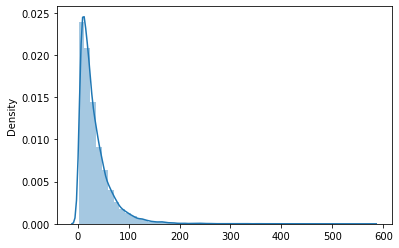

In [ ]:
# Comprobamos la distribución de las longitudes de secuencia para definir max_length
len_vec = [len(sent_vec) for sent_vec in train_sent1_seq]
np.max(len_vec)

sns.distplot(len_vec)

In [ ]:
# Definimos maxima longitud de secuencia
max_len = 260

In [ ]:
# Realizamos padding para igualar la longitud de las secuencias
train_sent1_seq = pad_sequences(train_sent1_seq, maxlen=max_len, padding='post')
train_sent2_seq = pad_sequences(train_sent2_seq, maxlen=max_len, padding='post')
val_sent1_seq = pad_sequences(val_sent1_seq, maxlen=max_len, padding='post')
val_sent2_seq = pad_sequences(val_sent2_seq, maxlen=max_len, padding='post')
test_sent1_seq = pad_sequences(test_sent1_seq, maxlen=max_len, padding='post')
test_sent2_seq = pad_sequences(test_sent2_seq, maxlen=max_len, padding='post')


## Load Muse Embeddings

In [ ]:
def read_muse_vecs(muse_file):
        with open(muse_file, 'r',  errors='ignore', encoding="utf-8") as f:
            words = set()
            word_to_vec_map = {}
            for line in f:
                line = line.strip().split()
                curr_word_list = line[0: len(line) - 300]
                curr_word = ""
                for t in curr_word_list:
                    curr_word = curr_word + str(t) + " "
                curr_word = curr_word.strip()
                words.add(curr_word)
                try:
                    word_to_vec_map[curr_word] = np.array(line[-300:], dtype=np.float64)
                except:
                    print(line, len(line))

            i = 1
            words_to_index = {}
            index_to_words = {}

            words.add("nokey")
            word_to_vec_map["nokey"] = np.zeros((300,), dtype=np.float64)

            for w in sorted(words):
                words_to_index[w] = i
                index_to_words[i] = w
                i = i + 1
        return words_to_index, index_to_words, word_to_vec_map

In [ ]:
%%capture
Pathjup = "muse/data/wiki.multi.en.vec"
Pathdrive = "/content/drive/MyDrive/muse/data/wiki.multi.en.vec"

words_to_index, index_to_words, word_to_vec_map = read_muse_vecs(Pathdrive)

In [ ]:
## Diccionario con word-embeddings(300)
#word_to_vec_map.keys()

In [ ]:
len(words_to_index) # Tamaño del vocabulario ingles

199989

In [ ]:
len(word_to_vec_map["no"]) # Embeddings palabra "right"

300

In [ ]:
#Creamos matriz de embeddings a partir del vocab de las review_body FULL
from numpy import zeros
embedding_matrix = zeros((vocab_size,300))
for word, i in t.word_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(22971, 300)

# Modelo red Siamesa

## Binary-cross entropy loss 

In [ ]:
from keras.regularizers import l2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling1D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Add, Conv2D,Bidirectional

In [ ]:
from keras import backend as K

def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

In [ ]:
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [ ]:
# Initialize wandb with your project name
run = wandb.init(project='Zero_shot_siamese',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.001,
                     "epochs": 3,
                     "batch_size": 64,
                     "loss_function": "binary_crossentropy",
                     "architecture": "BiLSTM"
                 })
config = wandb.config  # We'll use this to configure our experiment

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#Arquitectura del modelo
input_1 = Input(shape=(train_sent1_seq.shape[1],))
input_2 = Input(shape=(train_sent2_seq.shape[1],))


common_embed = Embedding(input_dim = vocab_size, output_dim=300,weights=[embedding_matrix], input_length= max_len,trainable=False) 

bilstm_1 = common_embed(input_1)
bilstm_2 = common_embed(input_2)


common_bilstm = Bidirectional(LSTM(128,return_sequences=True, activation="relu"))

vector_1 = common_bilstm(bilstm_1)
vector_1 = Flatten()(vector_1)

vector_2 = common_bilstm(bilstm_2)
vector_2 = Flatten()(vector_2)

x3 = Subtract()([vector_1, vector_2])
x3 = Multiply()([x3, x3])

x1_ = Multiply()([vector_1, vector_1])
x2_ = Multiply()([vector_2, vector_2])
x4 = Subtract()([x1_, x2_])
    
#https://stackoverflow.com/a/51003359/10650182
x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])
    
conc = Concatenate(axis=-1)([x5,x4, x3])

x = Dense(100, activation="relu", name='conc_layer')(conc)
x = Dropout(0.3)(x)
out = Dense(1, activation="sigmoid", name = 'out')(x)

model = Model([input_1, input_2], out)

model.compile(loss=config.loss_function, metrics=['acc'], optimizer=Adam(lr=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0))

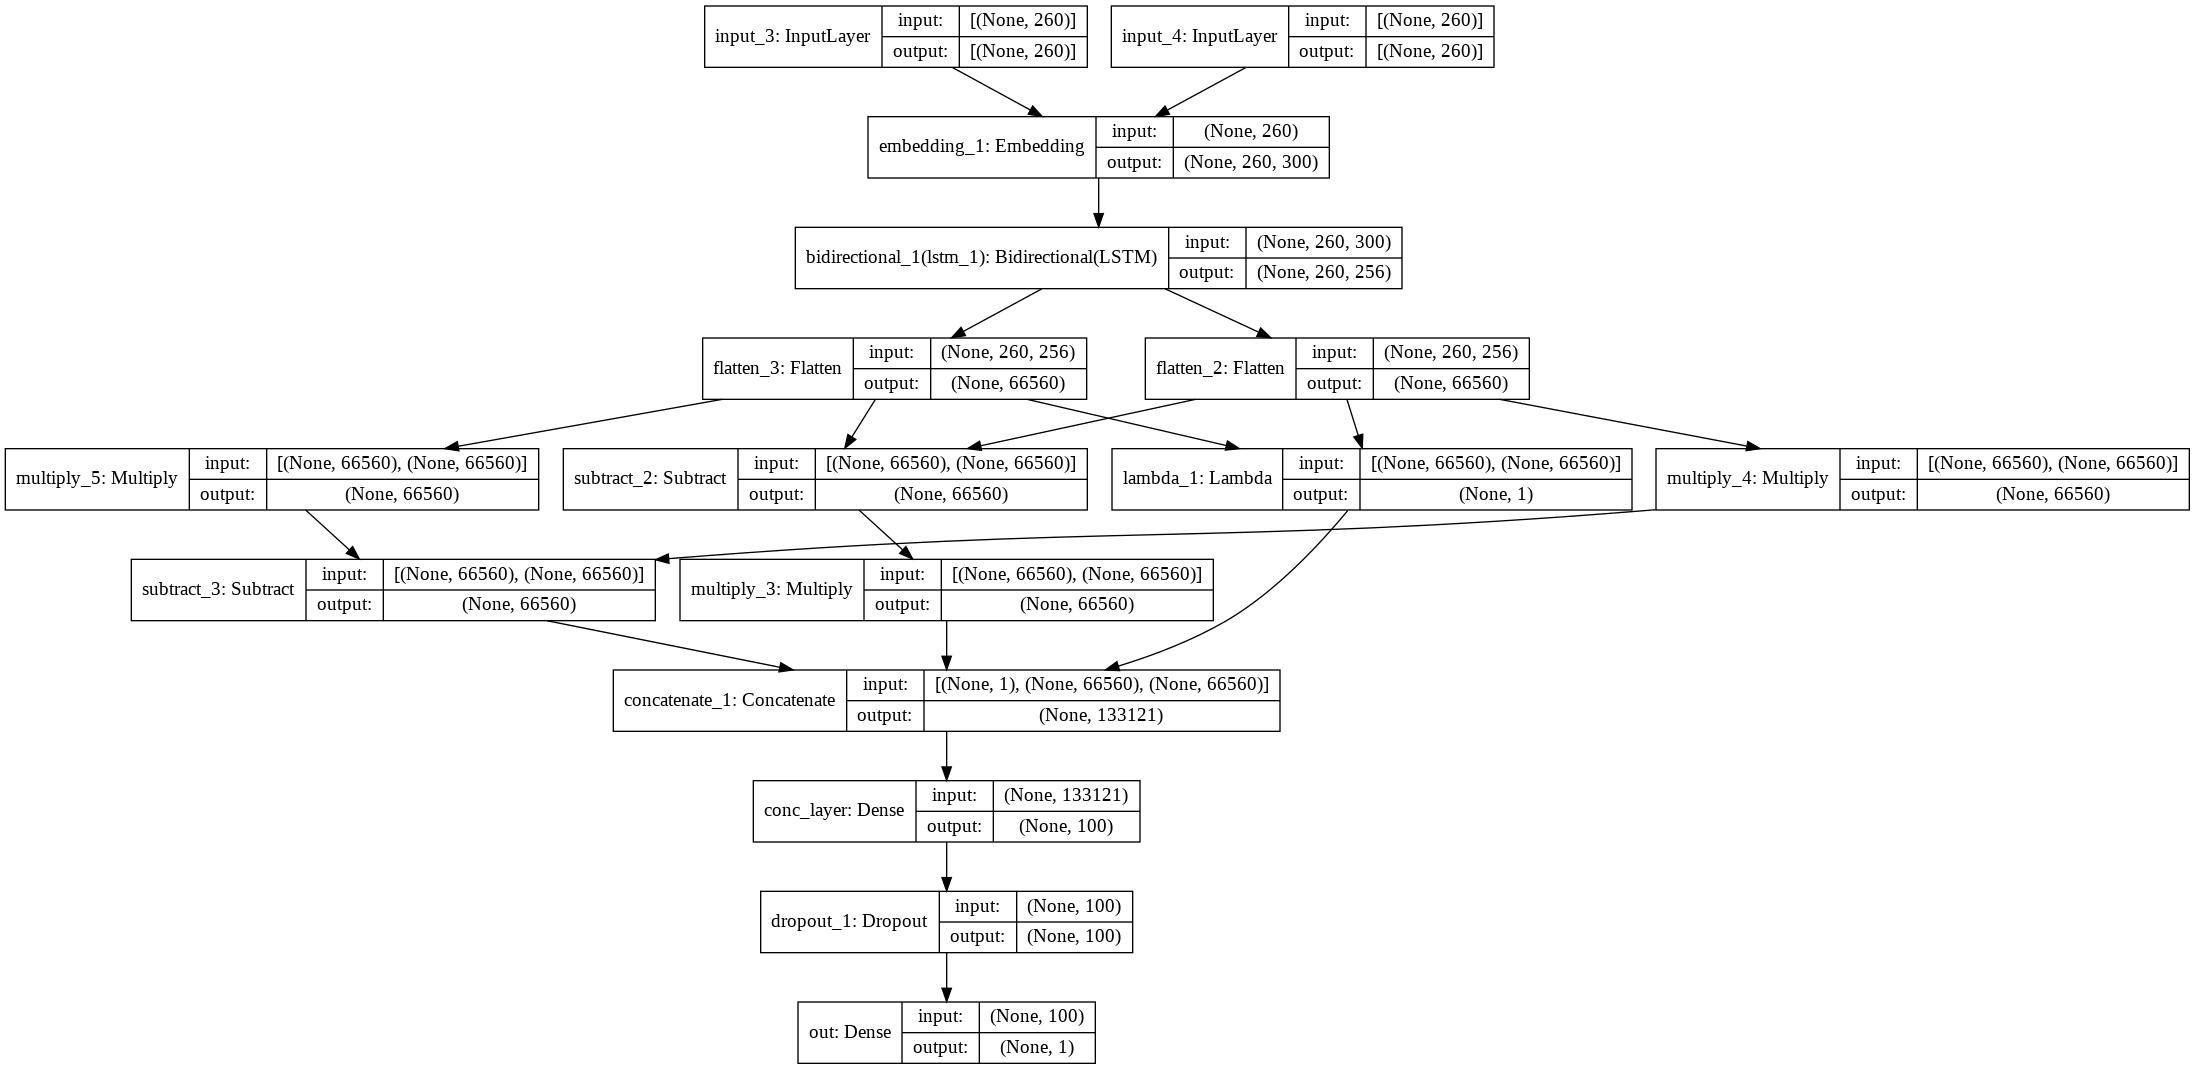

In [ ]:
from keras.utils import plot_model

plot_model(model, '/content/drive/MyDrive/TFG/model_arq/siamese.png', show_shapes=True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 260)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 260)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 260, 300)     6891300     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 260, 256)     439296      embedding[0][0]              

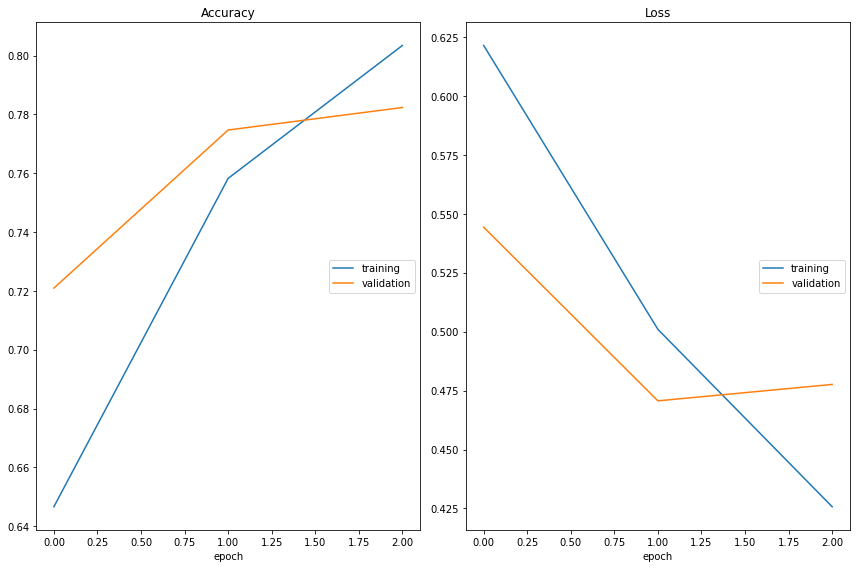

Accuracy
	training         	 (min:    0.647, max:    0.803, cur:    0.803)
	validation       	 (min:    0.721, max:    0.782, cur:    0.782)
Loss
	training         	 (min:    0.426, max:    0.621, cur:    0.426)
	validation       	 (min:    0.471, max:    0.544, cur:    0.478)


In [ ]:
X_train_final = [train_sent1_seq,train_sent2_seq]
X_val_final= [val_sent1_seq, val_sent2_seq]


y_train_final = y_train.values.reshape(-1,1)
y_val_final= y_val.values.reshape(-1,1)

model.fit(X_train_final, y_train_final,epochs=config.epochs,batch_size=config.batch_size,validation_data=(X_val_final, y_val_final),callbacks= [PlotLossesKeras(),WandbCallback()])


In [ ]:
wandb.finish()

epoch,2
loss,0.42573
acc,0.80344
val_loss,0.47761
val_acc,0.78234
_runtime,3438
_timestamp,1616014265
_step,2
best_val_loss,0.47064
best_epoch,1


epoch,▁▅█
loss,█▄▁
acc,▁▆█
val_loss,█▁▂
val_acc,▁▇█
_runtime,▁▄█
_timestamp,▁▄█
_step,▁▅█


In [ ]:
model.save("drive/MyDrive/TFG/siamese_2.h5")

In [ ]:
model_siamese = keras.models.load_model("drive/MyDrive/TFG/siamese_2.h5")

In [ ]:
X_test_final = [test_sent1_seq,test_sent2_seq]
y_test_final = y_test.values.reshape(-1,1)


y_pred_test = model_siamese.predict(X_test_final)


In [ ]:
y_pred_test_mapped= np.where(y_pred_test > 0.5, 1, 0)

In [ ]:
print(X_test['sent1'].values[110])
print(X_test['sent2'].values[110])
print(y_pred_test[110]) # similaridad
print(y_pred_test_mapped[110]) #clase

The desk looked great after assembling, which wasn't overly difficult. The box was well packed & instructions were adequate. My only complaint would be regard to the collar for wiring/cables to go thru - cheap, super thin plastic that cracked apart during assembly. Needs to be soft rubber.
Not what I expected but gets the job done.
[0.43280742]
[0]


In [ ]:
## Función evaluación dato  
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def eval_model(model,test_data,test_labels):

  """
  Recibe el modelo, el dato de test ya procesado (x idioma) y las true labels
  """
  loss,acc = model.evaluate(x=test_data, 
                            y=test_labels, 
                            batch_size=64, 
                            verbose=1)
  
  
  predictions = model.predict(test_data)
  predictions = np.where(predictions > 0.5, 1, 0)
  matrix = confusion_matrix(test_labels, predictions)
  plt.figure(figsize = (5,3))
  sns.heatmap(matrix/np.sum(matrix), annot=True, 
              fmt='.2%', cmap='Purples')
  plt.xlabel("Predicted class")
  plt.ylabel("True class") 

  clas_report = classification_report(test_labels, predictions)

  return print(clas_report)

126/126 [==============================] - 104s 822ms/step - loss: 0.4869 - acc: 0.7769
              precision    recall  f1-score   support

           0       0.82      0.71      0.76      3959
           1       0.75      0.85      0.79      4042

    accuracy                           0.78      8001
   macro avg       0.78      0.78      0.78      8001
weighted avg       0.78      0.78      0.78      8001



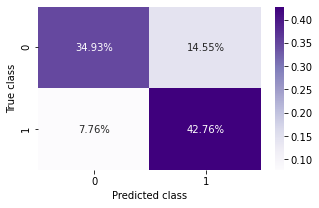

In [ ]:
eval_model(model_siamese,X_test_final,y_test_final)

#### Evaluación  en otros idiomas

In [ ]:
model_siamese = keras.models.load_model("drive/MyDrive/TFG/siamese_2.h5")

##### Dato Español

In [ ]:
## Import data pairs :

final_dataframe = pd.read_csv('drive/MyDrive/TFG/review_pairs_downsampled_ES.csv')
final_dataframe.head()

,sent1,sent2,is_duplicate
0,"El producto llegó antes de tiempo, pero no es ...",No me ha llegado todavía va tardisimo después ...,1
1,Me ha gustado ya que es muy aparente para expo...,No viene foto completa del puzzle. La unica fo...,0
2,Malísimo. Francamente no me sirve para nada po...,Era un regalo para mi hijo. Lo está usando y e...,0
3,"no ha durado ni un mes, cuando le pones la pil...","es una basura los botones se han caído, humeda...",1
4,No ajusta el botón con el espadín de la origin...,Por el precio que son estan muy bien. No se ve...,0


In [ ]:
# Dividimos el dato de entrenamiento

from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(final_dataframe[['sent1', 'sent2']], final_dataframe['is_duplicate'], test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(1280, 2)
(1280,)
(321, 2)
(321,)
(401, 2)
(401,)


In [ ]:
# Concatenación sentence 1 y sentence 2 para poder sacar el vocabulario de todos los textos
%%capture
X_train["text"] = X_train["sent1"] + " " + X_train["sent2"]


In [ ]:
X_train['text'] = X_train['text'].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
X_train.head()

,sent1,sent2,text
1419,"El disfraz es tal y como se ve en la foto, y l...",Buena e interesante información bastante actua...,"El disfraz es tal y como se ve en la foto, y l..."
1428,Una bonita historia en un relato breve. Para s...,pero no tiene nada especial que la distinga de...,Una bonita historia en un relato breve. Para s...
1305,Papel resistente. Portadas de tacto suave pero...,"Se ajusta a lo pedido, buen material, servido ...",Papel resistente. Portadas de tacto suave pero...
1067,Muy sencillo y de baja calidad,"Todo correcto, recibido en el plazo establecid...","Muy sencillo y de baja calidad Todo correcto, ..."
992,La tienda increíblemente atenta. No había vist...,"Cumple las expectativas, calidad precio bastan...",La tienda increíblemente atenta. No había vist...


In [ ]:
%%capture
import tensorflow as tf
import keras
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Concatenate, Conv2D, Flatten, Dense, Embedding, LSTM
from keras.models import Model

## Creamos tokenizer a partir de el vocabulario de la columna text (ambas sentences)
t = Tokenizer()
t.fit_on_texts(X_train['text'].values)
vocab_size = len(t.word_index)+1

## Convertimos a string
X_train['sent1'] = X_train['sent1'].astype(str)
X_train['sent2'] = X_train['sent2'].astype(str)

X_val['sent1'] = X_val['sent1'].astype(str)
X_val['sent2'] = X_val['sent2'].astype(str)

X_test['sent1'] = X_test['sent1'].astype(str)
X_test['sent2'] = X_test['sent2'].astype(str)

## Aplicamos text_to_sequences para pasar a secuencia

train_sent1_seq = t.texts_to_sequences(X_train['sent1'].values)
train_sent2_seq = t.texts_to_sequences(X_train['sent2'].values)
val_sent1_seq = t.texts_to_sequences(X_val['sent1'].values)
val_sent2_seq = t.texts_to_sequences(X_val['sent2'].values)
test_sent1_seq = t.texts_to_sequences(X_test['sent1'].values)
test_sent2_seq = t.texts_to_sequences(X_test['sent2'].values)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


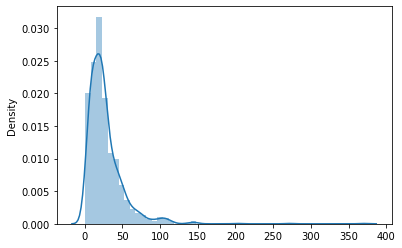

In [ ]:
# Comprobamos la distribución de las longitudes de secuencia para definir max_length
len_vec = [len(sent_vec) for sent_vec in train_sent1_seq]
np.max(len_vec)

sns.distplot(len_vec)

In [ ]:
# Definimos maxima longitud de secuencia
max_len = 260

In [ ]:
# Realizamos padding para igualar la longitud de las secuencias
train_sent1_seq = pad_sequences(train_sent1_seq, maxlen=max_len, padding='post')
train_sent2_seq = pad_sequences(train_sent2_seq, maxlen=max_len, padding='post')
val_sent1_seq = pad_sequences(val_sent1_seq, maxlen=max_len, padding='post')
val_sent2_seq = pad_sequences(val_sent2_seq, maxlen=max_len, padding='post')
test_sent1_seq = pad_sequences(test_sent1_seq, maxlen=max_len, padding='post')
test_sent2_seq = pad_sequences(test_sent2_seq, maxlen=max_len, padding='post')


In [ ]:
# Predict en Español
X_test_final_es = [test_sent1_seq,test_sent2_seq]
y_test_final_es = y_test.values.reshape(-1,1)

y_pred_test_es = model_siamese.predict(X_test_final_es)

7/7 [==============================] - 7s 929ms/step - loss: 0.9390 - acc: 0.5062
              precision    recall  f1-score   support

           0       0.51      0.32      0.39       200
           1       0.51      0.69      0.58       201

    accuracy                           0.51       401
   macro avg       0.51      0.51      0.49       401
weighted avg       0.51      0.51      0.49       401



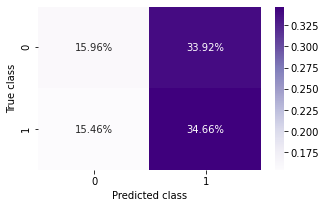

In [ ]:
eval_model(model_siamese,X_test_final_es,y_test_final_es)

##### Dato Frances

In [ ]:
## Import data pairs :

final_dataframe = pd.read_csv('drive/MyDrive/TFG/review_pairs_downsampled_FR.csv')
final_dataframe.head()

,sent1,sent2,is_duplicate
0,Produit introuvable dans les magasins de brico...,emballage individuel très bon mais le colissag...,1
1,dès que je l'ai reçu il a plu l'apres midi. et...,acheté il y a 4 mois pour mettre sur une tombe...,1
2,Acheter pour ma fille produit de bonne qualité,"Adapté pour le sony X compact, ne glisse pas (...",1
3,je n'ai pas reçu le produit j'ai un livre à la...,Remplacement ancien chargeur défectueux.,0
4,Pas très satisfait de ces lames que je pensais...,Ça laisse des traces au ventre c'est horrible,1


In [ ]:
# Dividimos el dato de entrenamiento

from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(final_dataframe[['sent1', 'sent2']], final_dataframe['is_duplicate'], test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(1278, 2)
(1278,)
(320, 2)
(320,)
(400, 2)
(400,)


In [ ]:
# Concatenación sentence 1 y sentence 2 para poder sacar el vocabulario de todos los textos
%%capture
X_train["text"] = X_train["sent1"] + " " + X_train["sent2"]


In [ ]:
X_train['text'] = X_train['text'].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
X_train.head()

,sent1,sent2,text
1404,Commande payer et pas reçu Envoyer plusieurs m...,La charge et l'ampérage sont très bon pour un ...,Commande payer et pas reçu Envoyer plusieurs m...
1185,Couvercle du sel défectueux ne ferme pas. On m...,Effectivement excellent appareil.de fitness..t...,Couvercle du sel défectueux ne ferme pas. On m...
48,"Bonjour, J'ai mis cette note pour la globalité...",Bin produit mais pas conforme a l image il man...,"Bonjour, J'ai mis cette note pour la globalité..."
1921,j'ai placé la 1ere vitre il y a 10 jours et el...,"On voit que c'est du toc, mais pour le prix c'...",j'ai placé la 1ere vitre il y a 10 jours et el...
60,"Bonjour, nous avons acheté cette calculatrice ...","Lot de 6 paires de chaussettes, top grande par...","Bonjour, nous avons acheté cette calculatrice ..."


In [ ]:
%%capture
import tensorflow as tf
import keras
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Concatenate, Conv2D, Flatten, Dense, Embedding, LSTM
from keras.models import Model

## Creamos tokenizer a partir de el vocabulario de la columna text (ambas sentences)
t = Tokenizer()
t.fit_on_texts(X_train['text'].values)
vocab_size = len(t.word_index)+1

## Convertimos a string
X_train['sent1'] = X_train['sent1'].astype(str)
X_train['sent2'] = X_train['sent2'].astype(str)

X_val['sent1'] = X_val['sent1'].astype(str)
X_val['sent2'] = X_val['sent2'].astype(str)

X_test['sent1'] = X_test['sent1'].astype(str)
X_test['sent2'] = X_test['sent2'].astype(str)

## Aplicamos text_to_sequences para pasar a secuencia

train_sent1_seq = t.texts_to_sequences(X_train['sent1'].values)
train_sent2_seq = t.texts_to_sequences(X_train['sent2'].values)
val_sent1_seq = t.texts_to_sequences(X_val['sent1'].values)
val_sent2_seq = t.texts_to_sequences(X_val['sent2'].values)
test_sent1_seq = t.texts_to_sequences(X_test['sent1'].values)
test_sent2_seq = t.texts_to_sequences(X_test['sent2'].values)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


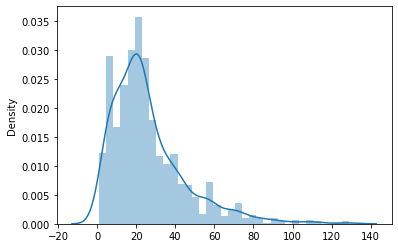

In [ ]:
# Comprobamos la distribución de las longitudes de secuencia para definir max_length
len_vec = [len(sent_vec) for sent_vec in train_sent1_seq]
np.max(len_vec)

sns.distplot(len_vec)

In [ ]:
# Definimos maxima longitud de secuencia
max_len = 260

In [ ]:
# Realizamos padding para igualar la longitud de las secuencias
train_sent1_seq = pad_sequences(train_sent1_seq, maxlen=max_len, padding='post')
train_sent2_seq = pad_sequences(train_sent2_seq, maxlen=max_len, padding='post')
val_sent1_seq = pad_sequences(val_sent1_seq, maxlen=max_len, padding='post')
val_sent2_seq = pad_sequences(val_sent2_seq, maxlen=max_len, padding='post')
test_sent1_seq = pad_sequences(test_sent1_seq, maxlen=max_len, padding='post')
test_sent2_seq = pad_sequences(test_sent2_seq, maxlen=max_len, padding='post')


In [ ]:
# Predict en Español
X_test_final_fr = [test_sent1_seq,test_sent2_seq]
y_test_final_fr = y_test.values.reshape(-1,1)

y_pred_test_es = model_siamese.predict(X_test_final_fr)

7/7 [==============================] - 6s 784ms/step - loss: 0.9594 - acc: 0.5000
              precision    recall  f1-score   support

           0       0.48      0.31      0.38       194
           1       0.51      0.67      0.58       206

    accuracy                           0.50       400
   macro avg       0.49      0.49      0.48       400
weighted avg       0.49      0.50      0.48       400



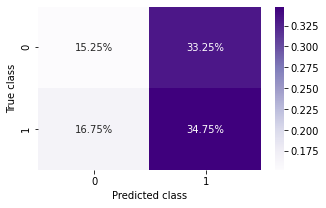

In [ ]:
eval_model(model_siamese,X_test_final_fr,y_test_final_fr)

##### Dato Aleman

In [ ]:
## Import data pairs :

final_dataframe = pd.read_csv('drive/MyDrive/TFG/review_pairs_downsampled_DE.csv')
final_dataframe.head()

,sent1,sent2,is_duplicate
0,Ist leider noch nicht bei mir angekommen. Lang...,"Sehr dünnes Material, gute Verarbeitung und mo...",0
1,Die Matte löst sich nach nur 6 Monaten im Wass...,Eigentlich kauft man sich eine Hülle um das Sm...,1
2,"Kann mich nur anschließen, dass der Service de...","Ich hab mich schon gewundert, dass eine Pumpe,...",1
3,Die Dinger halten nicht gut. Das verwendete do...,"Case liegt gut in der Hand, allerdings schirmt...",1
4,"Gutes Trampolin. Macht meinen Kindern (3,5 und...",Das Shirt fällt etwas breiter aus. Ansonsten b...,1


In [ ]:
# Dividimos el dato de entrenamiento

from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(final_dataframe[['sent1', 'sent2']], final_dataframe['is_duplicate'], test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(1286, 2)
(1286,)
(322, 2)
(322,)
(402, 2)
(402,)


In [ ]:
# Concatenación sentence 1 y sentence 2 para poder sacar el vocabulario de todos los textos
%%capture
X_train["text"] = X_train["sent1"] + " " + X_train["sent2"]


In [ ]:
X_train['text'] = X_train['text'].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
X_train.head()

,sent1,sent2,text
1059,Tut was sie soll und ist durch beigepackte Anl...,Ich habe das Produkt für mich und meine Tochte...,Tut was sie soll und ist durch beigepackte Anl...
1822,Sehr billiges Material und schlechte Qualität....,Ganz uns garnicht zufrieden habe die Hose wied...,Sehr billiges Material und schlechte Qualität....
872,Ich habe mir die Bumper gekauft da bei meinem ...,Habe bereits eine Form und habe nun endlich me...,Ich habe mir die Bumper gekauft da bei meinem ...
714,Der Diffuser wird gut verpackt verschickt und ...,"Sieht ok aus, schlechte Qualität",Der Diffuser wird gut verpackt verschickt und ...
1206,Sehr schön gestaltet! Hab es verschenkt an ein...,Leider nur bedingt zufriedenstellend bei leich...,Sehr schön gestaltet! Hab es verschenkt an ein...


In [ ]:
%%capture
import tensorflow as tf
import keras
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Concatenate, Conv2D, Flatten, Dense, Embedding, LSTM
from keras.models import Model

## Creamos tokenizer a partir de el vocabulario de la columna text (ambas sentences)
t = Tokenizer()
t.fit_on_texts(X_train['text'].values)
vocab_size = len(t.word_index)+1

## Convertimos a string
X_train['sent1'] = X_train['sent1'].astype(str)
X_train['sent2'] = X_train['sent2'].astype(str)

X_val['sent1'] = X_val['sent1'].astype(str)
X_val['sent2'] = X_val['sent2'].astype(str)

X_test['sent1'] = X_test['sent1'].astype(str)
X_test['sent2'] = X_test['sent2'].astype(str)

## Aplicamos text_to_sequences para pasar a secuencia

train_sent1_seq = t.texts_to_sequences(X_train['sent1'].values)
train_sent2_seq = t.texts_to_sequences(X_train['sent2'].values)
val_sent1_seq = t.texts_to_sequences(X_val['sent1'].values)
val_sent2_seq = t.texts_to_sequences(X_val['sent2'].values)
test_sent1_seq = t.texts_to_sequences(X_test['sent1'].values)
test_sent2_seq = t.texts_to_sequences(X_test['sent2'].values)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


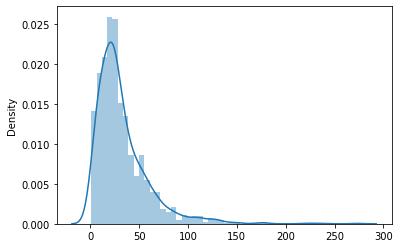

In [ ]:
# Comprobamos la distribución de las longitudes de secuencia para definir max_length
len_vec = [len(sent_vec) for sent_vec in train_sent1_seq]
np.max(len_vec)

sns.distplot(len_vec)

In [ ]:
# Definimos maxima longitud de secuencia
max_len = 260

In [ ]:
# Realizamos padding para igualar la longitud de las secuencias
train_sent1_seq = pad_sequences(train_sent1_seq, maxlen=max_len, padding='post')
train_sent2_seq = pad_sequences(train_sent2_seq, maxlen=max_len, padding='post')
val_sent1_seq = pad_sequences(val_sent1_seq, maxlen=max_len, padding='post')
val_sent2_seq = pad_sequences(val_sent2_seq, maxlen=max_len, padding='post')
test_sent1_seq = pad_sequences(test_sent1_seq, maxlen=max_len, padding='post')
test_sent2_seq = pad_sequences(test_sent2_seq, maxlen=max_len, padding='post')


In [ ]:
# Predict en Español
X_test_final_de = [test_sent1_seq,test_sent2_seq]
y_test_final_de = y_test.values.reshape(-1,1)

y_pred_test_es = model_siamese.predict(X_test_final_de)

7/7 [==============================] - 6s 770ms/step - loss: 0.9794 - acc: 0.5000
              precision    recall  f1-score   support

           0       0.52      0.29      0.37       205
           1       0.49      0.72      0.58       197

    accuracy                           0.50       402
   macro avg       0.51      0.50      0.48       402
weighted avg       0.51      0.50      0.48       402



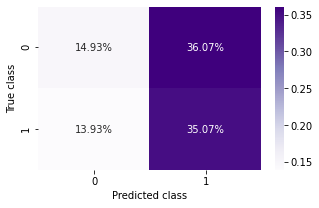

In [ ]:
eval_model(model_siamese,X_test_final_de,y_test_final_de)

## Contrastive Loss

In [ ]:
# import the necessary packages
import tensorflow.keras.backend as K
import tensorflow as tf
def contrastive_loss(y, preds, margin=1):
	# explicitly cast the true class label data type to the predicted
	# class label data type (otherwise we run the risk of having two
	# separate data types, causing TensorFlow to error out)
	y = tf.cast(y, preds.dtype)
	# calculate the contrastive loss between the true labels and
	# the predicted labels
	squaredPreds = K.square(preds)
	squaredMargin = K.square(K.maximum(margin - preds, 0))
	loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
	# return the computed contrastive loss to the calling function
	return loss

In [ ]:
input_1 = Input(shape=(train_sent1_seq.shape[1],))
input_2 = Input(shape=(train_sent2_seq.shape[1],))


common_embed = Embedding(input_dim = vocab_size, output_dim=300,weights=[embedding_matrix], input_length= max_len,trainable=False) 

bilstm_1 = common_embed(input_1)
bilstm_2 = common_embed(input_2)


common_bilstm = Bidirectional(LSTM(128,return_sequences=True, activation="relu"))

vector_1 = common_bilstm(bilstm_1)
vector_1 = Flatten()(vector_1)

vector_2 = common_bilstm(bilstm_2)
vector_2 = Flatten()(vector_2)

x3 = Subtract()([vector_1, vector_2])
x3 = Multiply()([x3, x3])

x1_ = Multiply()([vector_1, vector_1])
x2_ = Multiply()([vector_2, vector_2])
x4 = Subtract()([x1_, x2_])
    
    #https://stackoverflow.com/a/51003359/10650182
x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])
    
conc = Concatenate(axis=-1)([x5,x4, x3])

x = Dense(100, activation="relu", name='conc_layer')(conc)
x = Dropout(0.01)(x)
out = Dense(1, activation="sigmoid", name = 'out')(x)

model = Model([input_1, input_2], out)

## Cambiamos la funcion de perdida
model.compile(loss= contrastive_loss, metrics=['acc'], optimizer=Adam(lr=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0))

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 260)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 260)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 260, 300)     6891300     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 260, 256)     439296      embedding[0][0]              

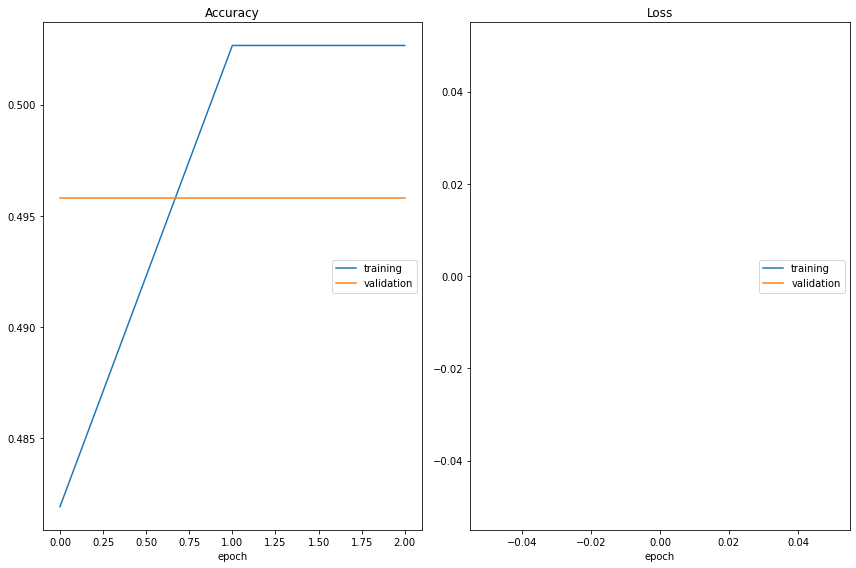

Accuracy
	training         	 (min:    0.482, max:    0.503, cur:    0.503)
	validation       	 (min:    0.496, max:    0.496, cur:    0.496)
Loss
	training         	 (min:      nan, max:      nan, cur:      nan)
	validation       	 (min:      nan, max:      nan, cur:      nan)


In [ ]:
X_train_final = [train_sent1_seq,train_sent2_seq]
X_val_final= [val_sent1_seq, val_sent2_seq]


y_train_final = y_train.values.reshape(-1,1)
y_val_final= y_val.values.reshape(-1,1)

model.fit(X_train_final, y_train_final,epochs=config.epochs,batch_size=config.batch_size,validation_data=(X_val_final, y_val_final),callbacks= [PlotLossesKeras(),WandbCallback()])


In [ ]:
model.save("drive/MyDrive/TFG/siamese_contrastive.h5")

In [ ]:
X_test_final = [test_sent1_seq,test_sent2_seq]
y_test_final = y_test.values.reshape(-1,1)

model.predict(X_test_final)

y_pred_test_mapped= np.where(y_pred_test > 0.5, 1, 0)

In [ ]:
print(X_test['sent1'].values[1])
print(X_test['sent2'].values[1])
print(y_pred_test[1])
print(y_pred_test_mapped[1])

This is the second one we purchased. The kettle stopped working on the other one and was out of warranty.
I did lose weight, in combination with other things, but this belt is not for smaller people! I have a short torso and the large part of my waistline was about 34". It was way, way too long for me and very hard to bend over while exercising. You will, however, sweat like a stuck hog at a state fair in July. Drink lots of water if you use anything neoprene.
[0.36168247]
[0]


In [ ]:
eval_model(model_siamese,X_test_final,y_test_final)

# Sweep de parámetros SIAMESE with Binary Cross_entropy

In [ ]:
X_train_final = [train_sent1_seq,train_sent2_seq]
X_val_final= [val_sent1_seq, val_sent2_seq]


y_train_final = y_train.values.reshape(-1,1)
y_val_final= y_val.values.reshape(-1,1)

X_test_final = [test_sent1_seq,test_sent2_seq]
y_test_final = y_test.values.reshape(-1,1)

In [ ]:
# Configure the sweep – specify the parameters to search through, the search strategy, the optimization metric et all.
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [5,8]
        },
        'batch_size': {
            'values': [128, 64]
        },
        'dropout': {
            'values': [0.3, 0.4]
        },

        'learning_rate': {
            'values': [1e-3, 3e-3,3e-4,1e-5]
        },
        'optimizer': {
            'values': ['adam']
        },
        'activation': {
            'values': ['sigmoid']
        }
    }
}

In [ ]:
# Initialize a new sweep
# Arguments:
#     – sweep_config: the sweep config dictionary defined above
#     – entity: Set the username for the sweep
#     – project: Set the project name for the sweep
sweep_id = wandb.sweep(sweep_config, entity="lucialarraona", project="Sweepslucia")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: nn08ycka
Sweep URL: https://wandb.ai/lucialarraona/Sweepslucia/sweeps/nn08ycka


In [ ]:
from keras.models import Sequential
from tensorflow.keras.layers import Embedding
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Bidirectional
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 5,
        'batch_size': 128,
        'learning_rate': 1e-3,
        'activation': 'sigmoid',
        'optimizer': 'adam',
        'dropout': 0.5,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model architecture 

    #Arquitectura del modelo
    input_1 = Input(shape=(train_sent1_seq.shape[1],))
    input_2 = Input(shape=(train_sent2_seq.shape[1],))


    common_embed = Embedding(input_dim = vocab_size, output_dim=300,weights=[embedding_matrix], input_length= max_len,trainable=False) 

    bilstm_1 = common_embed(input_1)
    bilstm_2 = common_embed(input_2)


    common_bilstm = Bidirectional(LSTM(128,return_sequences=True, activation="relu"))

    vector_1 = common_bilstm(bilstm_1)
    vector_1 = Flatten()(vector_1)

    vector_2 = common_bilstm(bilstm_2)
    vector_2 = Flatten()(vector_2)
    
    x3 = Subtract()([vector_1, vector_2])
    x3 = Multiply()([x3, x3])

    x1_ = Multiply()([vector_1, vector_1])
    x2_ = Multiply()([vector_2, vector_2])
    x4 = Subtract()([x1_, x2_])
        
    #https://stackoverflow.com/a/51003359/10650182
    x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])
        
    conc = Concatenate(axis=-1)([x5,x4, x3])

    x = Dense(100, activation="relu", name='conc_layer')(conc)
    x = Dropout(0.01)(x)
    out = Dense(1, activation="sigmoid", name = 'out')(x)

    model = Model([input_1, input_2], out)

    # Define the optimizer
 
    if config.optimizer=='adam':
      optimizer = Adam(lr=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics=['accuracy'])

    model.fit(X_train_final, y_train_final,
              epochs=config.epochs,
              batch_size=config.batch_size,
              validation_data=(X_val_final, y_val_final),
              callbacks=[WandbCallback(validation_data=(X_val_final, y_val_final))])

In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: b3p507z5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 8
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: Currently logged in as: lucialarraona (use `wandb login --relogin` to force relogin)


Epoch 1/8
400/400 [==============================] - 304s 746ms/step - loss: 0.6627 - accuracy: 0.5860 - val_loss: 0.5289 - val_accuracy: 0.7359
Epoch 2/8
400/400 [==============================] - 300s 748ms/step - loss: 0.5158 - accuracy: 0.7443 - val_loss: 0.4735 - val_accuracy: 0.7716
Epoch 3/8
400/400 [==============================] - 300s 748ms/step - loss: 0.4278 - accuracy: 0.8005 - val_loss: 0.4708 - val_accuracy: 0.7734
Epoch 4/8
400/400 [==============================] - 292s 729ms/step - loss: 0.3341 - accuracy: 0.8581 - val_loss: 0.4885 - val_accuracy: 0.7800
Epoch 5/8
400/400 [==============================] - 292s 730ms/step - loss: 0.2350 - accuracy: 0.9044 - val_loss: 0.5683 - val_accuracy: 0.7720
Epoch 6/8
400/400 [==============================] - 300s 751ms/step - loss: 0.1500 - accuracy: 0.9426 - val_loss: 0.7099 - val_accuracy: 0.7697
Epoch 7/8
400/400 [==============================] - 298s 745ms/step - loss: 0.0911 - accuracy: 0.9680 - val_loss: 0.7853 - val_ac

epoch,7
loss,0.06547
accuracy,0.97805
val_loss,0.9721
val_accuracy,0.76719
_runtime,2394
_timestamp,1616933316
_step,7
best_val_loss,0.47076
best_epoch,2


epoch,▁▂▃▄▅▆▇█
loss,█▆▆▄▃▂▁▁
accuracy,▁▃▄▅▆▇██
val_loss,▂▁▁▁▂▄▅█
val_accuracy,▁▇▇█▇▆█▆
_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█


wandb: Agent Starting Run: xbqppllz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 8
wandb: 	learning_rate: 0.003
wandb: 	optimizer: adam


Epoch 1/8
400/400 [==============================] - 306s 758ms/step - loss: 0.6510 - accuracy: 0.5873 - val_loss: 0.4994 - val_accuracy: 0.7517
Epoch 2/8
400/400 [==============================] - 304s 760ms/step - loss: 0.4769 - accuracy: 0.7649 - val_loss: 0.4682 - val_accuracy: 0.7706
Epoch 3/8
400/400 [==============================] - 306s 763ms/step - loss: 0.3693 - accuracy: 0.8366 - val_loss: 0.4594 - val_accuracy: 0.7872
Epoch 4/8
400/400 [==============================] - 297s 741ms/step - loss: 0.2531 - accuracy: 0.8953 - val_loss: 0.5200 - val_accuracy: 0.7869
Epoch 5/8
400/400 [==============================] - 289s 723ms/step - loss: 0.1548 - accuracy: 0.9411 - val_loss: 0.6318 - val_accuracy: 0.7709
Epoch 6/8
400/400 [==============================] - 294s 735ms/step - loss: 0.0985 - accuracy: 0.9681 - val_loss: 0.8501 - val_accuracy: 0.7498
Epoch 7/8
400/400 [==============================] - 294s 735ms/step - loss: 0.0620 - accuracy: 0.9801 - val_loss: 0.9274 - val_ac

epoch,7
loss,0.04212
accuracy,0.98645
val_loss,1.09195
val_accuracy,0.77156
_runtime,2390
_timestamp,1616935714
_step,7
best_val_loss,0.45943
best_epoch,2


epoch,▁▂▃▄▅▆▇█
loss,█▆▅▄▃▂▁▁
accuracy,▁▃▅▆▇███
val_loss,▁▁▁▂▃▅▆█
val_accuracy,▁▅██▅▁▅▅
_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█


wandb: Agent Starting Run: yn4fw7je with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 8
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam


Epoch 1/8
200/200 [==============================] - 153s 748ms/step - loss: 0.6857 - accuracy: 0.5370 - val_loss: 0.6421 - val_accuracy: 0.6286
Epoch 2/8
200/200 [==============================] - 149s 742ms/step - loss: 0.6234 - accuracy: 0.6515 - val_loss: 0.6125 - val_accuracy: 0.6945
Epoch 3/8
200/200 [==============================] - 151s 750ms/step - loss: 0.5548 - accuracy: 0.7182 - val_loss: 0.5272 - val_accuracy: 0.7416
Epoch 4/8
200/200 [==============================] - 155s 771ms/step - loss: 0.4974 - accuracy: 0.7611 - val_loss: 0.5055 - val_accuracy: 0.7577
Epoch 5/8
200/200 [==============================] - 152s 760ms/step - loss: 0.4751 - accuracy: 0.7769 - val_loss: 0.4962 - val_accuracy: 0.7617
Epoch 6/8
200/200 [==============================] - 151s 753ms/step - loss: 0.4433 - accuracy: 0.7904 - val_loss: 0.4902 - val_accuracy: 0.7680
Epoch 7/8
200/200 [==============================] - 154s 765ms/step - loss: 0.3956 - accuracy: 0.8245 - val_loss: 0.5076 - val_ac

epoch,7
loss,0.36113
accuracy,0.84145
val_loss,0.51566
val_accuracy,0.75703
_runtime,1220
_timestamp,1616936943
_step,7
best_val_loss,0.49023
best_epoch,5


epoch,▁▂▃▄▅▆▇█
loss,█▇▅▄▄▃▂▁
accuracy,▁▄▅▆▆▇▇█
val_loss,█▇▃▂▁▁▂▂
val_accuracy,▁▄▇▇███▇
_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█


wandb: Agent Starting Run: d00fbnxg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/5
200/200 [==============================] - 155s 761ms/step - loss: 0.6707 - accuracy: 0.5730 - val_loss: 0.5692 - val_accuracy: 0.7147
Epoch 2/5
200/200 [==============================] - 152s 759ms/step - loss: 0.5445 - accuracy: 0.7230 - val_loss: 0.5150 - val_accuracy: 0.7484
Epoch 3/5
200/200 [==============================] - 149s 745ms/step - loss: 0.4750 - accuracy: 0.7723 - val_loss: 0.4749 - val_accuracy: 0.7758
Epoch 4/5
200/200 [==============================] - 151s 754ms/step - loss: 0.3846 - accuracy: 0.8264 - val_loss: 0.4787 - val_accuracy: 0.7800
Epoch 5/5
200/200 [==============================] - 152s 762ms/step - loss: 0.3117 - accuracy: 0.8651 - val_loss: 0.4958 - val_accuracy: 0.7722


epoch,4
loss,0.31541
accuracy,0.86406
val_loss,0.4958
val_accuracy,0.77219
_runtime,763
_timestamp,1616937713
_step,4
best_val_loss,0.47494
best_epoch,2


epoch,▁▃▅▆█
loss,█▆▄▃▁
accuracy,▁▄▆▇█
val_loss,█▄▁▁▃
val_accuracy,▁▅██▇
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: udt647o5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 8
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/8
200/200 [==============================] - 153s 750ms/step - loss: 0.6931 - accuracy: 0.5092 - val_loss: 0.6931 - val_accuracy: 0.5072
Epoch 2/8
200/200 [==============================] - 149s 743ms/step - loss: 0.6928 - accuracy: 0.5297 - val_loss: 0.6925 - val_accuracy: 0.5327
Epoch 3/8
200/200 [==============================] - 152s 759ms/step - loss: 0.6919 - accuracy: 0.5423 - val_loss: 0.6909 - val_accuracy: 0.5467
Epoch 4/8
200/200 [==============================] - 151s 755ms/step - loss: 0.6889 - accuracy: 0.5628 - val_loss: 0.6863 - val_accuracy: 0.5622
Epoch 5/8
200/200 [==============================] - 153s 762ms/step - loss: 0.6815 - accuracy: 0.5787 - val_loss: 0.6780 - val_accuracy: 0.5867
Epoch 6/8
200/200 [==============================] - 153s 764ms/step - loss: 0.6728 - accuracy: 0.5925 - val_loss: 0.6742 - val_accuracy: 0.5948
Epoch 7/8
200/200 [==============================] - 150s 747ms/step - loss: 0.6694 - accuracy: 0.5974 - val_loss: 0.6733 - val_ac

epoch,7
loss,0.66428
accuracy,0.60672
val_loss,0.66862
val_accuracy,0.60266
_runtime,1214
_timestamp,1616938934
_step,7
best_val_loss,0.66862
best_epoch,7


epoch,▁▂▃▄▅▆▇█
loss,███▇▅▃▂▁
accuracy,▁▃▄▅▆▇██
val_loss,██▇▆▄▃▂▁
val_accuracy,▁▃▄▅▇▇▇█
_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█


wandb: Agent Starting Run: eg12dmia with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	learning_rate: 0.003
wandb: 	optimizer: adam


Epoch 1/5
400/400 [==============================] - 299s 738ms/step - loss: 0.6478 - accuracy: 0.6089 - val_loss: 0.5072 - val_accuracy: 0.7525
Epoch 2/5
400/400 [==============================] - 304s 758ms/step - loss: 0.4886 - accuracy: 0.7641 - val_loss: 0.4778 - val_accuracy: 0.7708
Epoch 3/5
400/400 [==============================] - 304s 761ms/step - loss: 0.3862 - accuracy: 0.8216 - val_loss: 0.4709 - val_accuracy: 0.7867
Epoch 4/5
400/400 [==============================] - 306s 764ms/step - loss: 0.2593 - accuracy: 0.8933 - val_loss: 0.4902 - val_accuracy: 0.7867
Epoch 5/5
400/400 [==============================] - 301s 753ms/step - loss: 0.1592 - accuracy: 0.9412 - val_loss: 0.6017 - val_accuracy: 0.7783


epoch,4
loss,0.16632
accuracy,0.9366
val_loss,0.60165
val_accuracy,0.77828
_runtime,1518
_timestamp,1616940461
_step,4
best_val_loss,0.47094
best_epoch,2


epoch,▁▃▅▆█
loss,█▆▄▃▁
accuracy,▁▄▅▇█
val_loss,▃▁▁▂█
val_accuracy,▁▅██▆
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: u8y6mc5m with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 8
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam


Epoch 1/8
400/400 [==============================] - 302s 748ms/step - loss: 0.6808 - accuracy: 0.5528 - val_loss: 0.6077 - val_accuracy: 0.6639
Epoch 2/8
400/400 [==============================] - 306s 762ms/step - loss: 0.5913 - accuracy: 0.6823 - val_loss: 0.5585 - val_accuracy: 0.7159
Epoch 3/8
400/400 [==============================] - 308s 769ms/step - loss: 0.5421 - accuracy: 0.7252 - val_loss: 0.5290 - val_accuracy: 0.7327
Epoch 4/8
400/400 [==============================] - 309s 772ms/step - loss: 0.4906 - accuracy: 0.7614 - val_loss: 0.4882 - val_accuracy: 0.7622
Epoch 5/8
400/400 [==============================] - 302s 755ms/step - loss: 0.4459 - accuracy: 0.7888 - val_loss: 0.4822 - val_accuracy: 0.7667
Epoch 6/8
400/400 [==============================] - 309s 772ms/step - loss: 0.3965 - accuracy: 0.8171 - val_loss: 0.4852 - val_accuracy: 0.7728
Epoch 7/8
400/400 [==============================] - 310s 774ms/step - loss: 0.4208 - accuracy: 0.7735 - val_loss: 0.6932 - val_ac

epoch,7
loss,0.69331
accuracy,0.49734
val_loss,0.69311
val_accuracy,0.50422
_runtime,2458
_timestamp,1616942927
_step,7
best_val_loss,0.48222
best_epoch,4


epoch,▁▂▃▄▅▆▇█
loss,▇▅▄▃▂▁▄█
accuracy,▃▅▆▇▇█▄▁
val_loss,▅▄▃▁▁▁██
val_accuracy,▅▇▇███▁▁
_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█


wandb: Agent Starting Run: evo86fp3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam


Epoch 1/5
400/400 [==============================] - 304s 753ms/step - loss: 0.6787 - accuracy: 0.5499 - val_loss: 0.6397 - val_accuracy: 0.6519
Epoch 2/5
400/400 [==============================] - 294s 735ms/step - loss: 0.5871 - accuracy: 0.6825 - val_loss: 0.5525 - val_accuracy: 0.7269
Epoch 3/5
400/400 [==============================] - 294s 735ms/step - loss: 0.5256 - accuracy: 0.7372 - val_loss: 0.4978 - val_accuracy: 0.7580
Epoch 4/5
400/400 [==============================] - 295s 737ms/step - loss: 0.4815 - accuracy: 0.7684 - val_loss: 0.4991 - val_accuracy: 0.7559
Epoch 5/5
400/400 [==============================] - 298s 744ms/step - loss: 0.4284 - accuracy: 0.7977 - val_loss: 0.4820 - val_accuracy: 0.7731


epoch,4
loss,0.42497
accuracy,0.80098
val_loss,0.48201
val_accuracy,0.77312
_runtime,1490
_timestamp,1616944425
_step,4
best_val_loss,0.48201
best_epoch,4


epoch,▁▃▅▆█
loss,█▆▄▂▁
accuracy,▁▄▆▇█
val_loss,█▄▂▂▁
val_accuracy,▁▅▇▇█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 0fz8qbi0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	learning_rate: 0.003
wandb: 	optimizer: adam


Epoch 1/5
400/400 [==============================] - 296s 731ms/step - loss: 0.6489 - accuracy: 0.6132 - val_loss: 0.5474 - val_accuracy: 0.7169
Epoch 2/5
400/400 [==============================] - 294s 732ms/step - loss: 0.4959 - accuracy: 0.7562 - val_loss: 0.4612 - val_accuracy: 0.7800
Epoch 3/5
400/400 [==============================] - 293s 730ms/step - loss: 0.3867 - accuracy: 0.8229 - val_loss: 0.4660 - val_accuracy: 0.7803
Epoch 4/5
400/400 [==============================] - 301s 753ms/step - loss: 0.2677 - accuracy: 0.8876 - val_loss: 0.5145 - val_accuracy: 0.7802
Epoch 5/5
400/400 [==============================] - 296s 740ms/step - loss: 0.1651 - accuracy: 0.9356 - val_loss: 0.6804 - val_accuracy: 0.7688


epoch,4
loss,0.1736
accuracy,0.9316
val_loss,0.68036
val_accuracy,0.76875
_runtime,1483
_timestamp,1616945920
_step,4
best_val_loss,0.46118
best_epoch,1


epoch,▁▃▅▆█
loss,█▆▄▃▁
accuracy,▁▄▅▇█
val_loss,▄▁▁▃█
val_accuracy,▁███▇
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 38jsrkj9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam


Epoch 1/5
400/400 [==============================] - 295s 730ms/step - loss: 0.6917 - accuracy: 0.5097 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 2/5
400/400 [==============================] - 291s 728ms/step - loss: 0.6931 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 3/5
400/400 [==============================] - 292s 730ms/step - loss: 0.6931 - accuracy: 0.5057 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 4/5
400/400 [==============================] - 302s 755ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.4958
Epoch 5/5
400/400 [==============================] - 298s 746ms/step - loss: 0.6931 - accuracy: 0.5037 - val_loss: 0.6932 - val_accuracy: 0.4958


epoch,4
loss,0.69314
accuracy,0.50266
val_loss,0.6932
val_accuracy,0.49578
_runtime,1482
_timestamp,1616947411
_step,4
best_val_loss,0.69315
best_epoch,0


epoch,▁▃▅▆█
loss,▁████
accuracy,█▁▄▄▄
val_loss,▁▃▄▆█
val_accuracy,▁▁▁▁▁
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: rgiblf49 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 8
wandb: 	learning_rate: 0.003
wandb: 	optimizer: adam


Epoch 1/8
200/200 [==============================] - 152s 746ms/step - loss: 0.6568 - accuracy: 0.5882 - val_loss: 0.5213 - val_accuracy: 0.7406
Epoch 2/8
200/200 [==============================] - 149s 741ms/step - loss: 0.4993 - accuracy: 0.7565 - val_loss: 0.4682 - val_accuracy: 0.7758
Epoch 3/8
200/200 [==============================] - 149s 746ms/step - loss: 0.3921 - accuracy: 0.8228 - val_loss: 0.4556 - val_accuracy: 0.7864
Epoch 4/8
200/200 [==============================] - 152s 760ms/step - loss: 0.2889 - accuracy: 0.8751 - val_loss: 0.4853 - val_accuracy: 0.7928
Epoch 5/8
200/200 [==============================] - 150s 752ms/step - loss: 0.1836 - accuracy: 0.9264 - val_loss: 0.6018 - val_accuracy: 0.7802
Epoch 6/8
200/200 [==============================] - 149s 743ms/step - loss: 0.1172 - accuracy: 0.9570 - val_loss: 0.7484 - val_accuracy: 0.7797
Epoch 7/8
200/200 [==============================] - 149s 744ms/step - loss: 0.0712 - accuracy: 0.9779 - val_loss: 0.8255 - val_ac

epoch,7
loss,0.05303
accuracy,0.98266
val_loss,1.03383
val_accuracy,0.76531
_runtime,1205
_timestamp,1616948625
_step,7
best_val_loss,0.45556
best_epoch,2


epoch,▁▂▃▄▅▆▇█
loss,█▆▅▄▃▂▁▁
accuracy,▁▃▅▆▇▇██
val_loss,▂▁▁▁▃▅▅█
val_accuracy,▁▆▇█▆▆▆▄
_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█


wandb: Agent Starting Run: b5xmmwca with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 8
wandb: 	learning_rate: 0.003
wandb: 	optimizer: adam


Epoch 1/8
400/400 [==============================] - 300s 740ms/step - loss: 0.6493 - accuracy: 0.6081 - val_loss: 0.5463 - val_accuracy: 0.7155
Epoch 2/8
400/400 [==============================] - 286s 714ms/step - loss: 0.4987 - accuracy: 0.7524 - val_loss: 0.4795 - val_accuracy: 0.7706
Epoch 3/8
400/400 [==============================] - 291s 726ms/step - loss: 229.3285 - accuracy: 0.8176 - val_loss: 0.4692 - val_accuracy: 0.7789
Epoch 4/8
400/400 [==============================] - 296s 739ms/step - loss: 0.2789 - accuracy: 0.8808 - val_loss: 0.5180 - val_accuracy: 0.7777
Epoch 5/8
135/400 [=========>....................] - ETA: 2:59 - loss: 0.1709 - accuracy: 0.9335